# 200 Project 2 Data Cleaning & EDA 
#### Lucy Herr
#### W200 Project 2
#### December 9, 2022


## Process:
- 1. combine quarterly summary expensitures datasets for years 2016-2017 (8 in total)
- 2. clean combined summary dataset: check column types, address null values, identify subsets and/or columns to drop 
- 3. drop and document any unused colums and row subsets 
    - subset only the rows without null values "BIOGUIDE_ID" (which designate groups & can't easily be linked to specific individuals)
    - ***bio guide id: check any missing values and impute wherever possible (document any exclusions)*** 
- sanity check: outliers for main vars, amounts, etc. 
    - plot basic category/amount breakdown, etc. 
- CLEAN supplementary congress Bioguide ID dataset: 
    - format "congresses" column into separate columns for representatives' party and state
    - general data formatting: check types, etc. 
    - drop unused colums and rename remaining ones consistently before merge 
- Merge 2 datasets
    - sanity check: number of unique bioguide ID's vs. expected number of House representatives per year 
- drop group/committee offices and District/Territory members; manually add party data for few reps with missing info 
- basic descriptive stats/visualizations
    - reps by party, per year  
- plan groupby/agg approach for visualizations


## Running assumption list: 
- limit scope to 2016-2017 (team decision)  
- exclude groups (comittees, etc.) from party analysis 
- use non-totals to calculate expenditures totals due to discrepancies between values labeled "totals" and sums of values not labeled as totals  (see discussion in report, original data documentation from propublica)
- OK to impute individual rep data (for party info) based on office name where applicable 
    - included leadership offices (e.g., Speaker or Minority Whip)
    - included 3 Reps with missing info in supplementary data (these may be due to off-term elections as result of resignations)
    - excluded District/Territory members because they have limited roles in House 
        - example: HON. JENNIFFER GONZALEZ-COLON': Resident Commissioner, Puerto Rico, District At Large 115th-117th (2017-Present)
        - "Non-voting member" the house with different term (4 years) and can't vote on proposed legislation
- don't need to convert 2017 fiscal year to regular quarters since these were filtered out with committee/group offices 
    - 897 total fiscal year rows in raw data 
- OK to use the last entry in each rep's congress list (e.g. most recent) to obtain party information 
- excluding negative expenses because we can't determine whether these represent errors or legitimate refunds/corrections
    - 184 total negative amount values 
    - there aren't many negative amount values, but some of them are so large that it's worth discussing and documemnting them. however, they can't be accurately summed/aggregated with the other expenses.
- it turns out, the vast majority of the observations with missing category info are for individual representatives' expenses (all of the rows with missing categories are in 2016Q4, 2017Q1, or 2017Q2, so this must be an artifact of the 2 additional columns, program and description, in those quarterly datasets). I'm making the argument that these are worth trying to "impute" with the program/description columns in order to present substantial loss of information otehrwise 
- it appears that some category values are aligned with program columns values, while others are aligned with description values. unfortunately, there's not really an easy way to get to the ground truth at this point as to what type of values should be contained in each category vs. the other columns (without expert input). I made the decision to replace the missing categories with description values (to be consistent)
    - important to note: the rationale for excluding these is the non-individual representatives (not the fiscal year)


In [717]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.ticker as mtick
import plotly.express as px
%matplotlib inline

In [718]:
# look at summary-level house expenditure data for single quarter (2018 q1) 
#house_summary_q1_2018_df = pd.read_csv('2018Q1-house-disburse-summary.csv')

In [719]:
#house_summary_q1_2018_df.head()

In [720]:
#house_summary_q1_2018_df.info()

In [721]:
#house_summary_q1_2018_df.describe()

In [722]:
# look at detail-level house expenditure data for single quarter (2018 q1) 
#house_detail_q1_2018_df = pd.read_csv('2018Q1-house-disburse-detail.csv')

In [723]:
# try combining all summary quarter csvs simultanously  
# import os
# path = "project_2_summary_data"

# # list all files in the directory, assuming this directory 
# # contains only files csv files that you need to save 
# df_list = []
# for file in os.listdir(path): # os.listdir(path):
#     df = pd.read_csv(path+file)
#     df_list.append(df)
# combined_df = pd.concat(df_list)

I'm clearly getting something wrong here, but in the interest of time I will combine them with a bunch of copy and pasting 

In [724]:
Q1_2016_sum_df = pd.read_csv('project_2_summary_data/2016Q1-house-disburse-summary.csv')
Q2_2016_sum_df = pd.read_csv('project_2_summary_data/2016Q2-house-disburse-summary.csv')
Q3_2016_sum_df = pd.read_csv('project_2_summary_data/2016Q3-house-disburse-summary.csv')
Q4_2016_sum_df = pd.read_csv('project_2_summary_data/2016Q4-house-disburse-summary.csv')
Q1_2017_sum_df = pd.read_csv('project_2_summary_data/2017Q1-house-disburse-summary.csv')
Q2_2017_sum_df = pd.read_csv('project_2_summary_data/2017Q2-house-disburse-summary.csv')
Q3_2017_sum_df = pd.read_csv('project_2_summary_data/2017Q3-house-disburse-summary.csv')
Q4_2017_sum_df = pd.read_csv('project_2_summary_data/2017Q4-house-disburse-summary.csv')

In [725]:
# combine all quarter dfs 
df_sum_list = [Q1_2016_sum_df, Q2_2016_sum_df, Q3_2016_sum_df, Q4_2016_sum_df,
               Q1_2017_sum_df, Q2_2017_sum_df, Q3_2017_sum_df, Q4_2017_sum_df]        
summ_Q116toQ417_df = pd.concat(df_sum_list)
summ_Q116toQ417_df.shape

(37802, 9)

- combined raw summary dataset for all quarters 2016-2017: 37802 expense observations 

In [726]:
# check column alignment: 
for d in df_sum_list:
    print(d.columns, end = "")

Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'CATEGORY', 'YTD',
       'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'CATEGORY', 'YTD',
       'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'CATEGORY', 'YTD',
       'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'PROGRAM', 'DESCRIPTION',
       'YTD', 'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'PROGRAM', 'DESCRIPTION',
       'YTD', 'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'PROGRAM', 'DESCRIPTION',
       'YTD', 'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'PROGRAM', 'CATEGORY',
       'YTD', 'AMOUNT'],
      dtype='object')Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'CATEGORY', 'YTD',
       'AMOUNT'],
      dtype='object')

***important to note:*** only 3 quarters have the 'DESCRIPTION' and 'PROGRAM' columns!

In [727]:
summ_Q116toQ417_df.to_csv('summ_2016_2017_df_raw.csv')

## Look at each column in combined summary df (datatype, range, missing values, etc.):  

### 1. BIOGUIDE ID 

In [728]:
summ_Q116toQ417_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37802 entries, 0 to 5092
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   BIOGUIDE_ID  32809 non-null  object
 1   OFFICE       37802 non-null  object
 2   YEAR         37802 non-null  object
 3   QUARTER      37802 non-null  object
 4   CATEGORY     22429 non-null  object
 5   YTD          37802 non-null  object
 6   AMOUNT       37802 non-null  object
 7   PROGRAM      20655 non-null  object
 8   DESCRIPTION  15373 non-null  object
dtypes: object(9)
memory usage: 2.9+ MB


In [729]:
len(summ_Q116toQ417_df.BIOGUIDE_ID.unique())

507

- 4993 of 37802 entries have bioguide IDs
- 507 unique bioguide ids (seems reasonable based on number of reps in house) 

In [730]:
summ_Q116toQ417_df_noid = summ_Q116toQ417_df[summ_Q116toQ417_df['BIOGUIDE_ID'].isnull()]

In [731]:
# make list of offices with individual reps to clean & keep in data 
summ_Q116toQ417_df_noid['OFFICE'].unique()

array(['OFFICE OF THE SPEAKER', 'OFFICE OF THE MAJORITY LEADER',
       'OFFICE OF THE MINORITY LEADER', 'OFFICE OF THE MAJORITY WHIP',
       'OFFICE OF THE MINORITY WHIP', 'DEMOCRATIC CAUCUS',
       'REPUBLICAN CONFERENCE', 'CHIEF ADMIN OFCR OF THE HOUSE',
       'CLERK OF THE HOUSE', 'OFFICE OF GENERAL COUNSEL',
       'SERGEANT AT ARMS', 'OFFICE OF THE PARLIAMENTARIAN',
       'COMPILATION OF PRECEDENTS', 'TECHNICAL ASSISTANTS',
       "FORMER SPEAKER'S STAFF", 'OFFICE OF INSPECTOR GENERAL',
       'LAW REVISION COUNSEL', 'LEGISLATIVE COUNSEL',
       'INTERPARLIAMENTARY AFFAIRS', 'CAO ADVANCED BUSINESS SOLUTION',
       'EMD', 'CAO IMMEDIATE OFFICE', 'TECHNOLOGY INFRASTRUCTURE',
       'FURNISHINGS', 'LIFE CYCLE REPLACEMENT', 'HOUSE RECORDING STUDIO',
       'COMMITTEE RENOVATION PROJECT', 'HON. 8TH DISTRICT OF OHIO',
       'OTHER ADMINISTRATION', 'COMMITTEE ON APPROPRIATIONS',
       'COMMITTEE ON BUDGET', 'COMMITTEE ON AGRICULTURE',
       'ARMED SERVICES COMMITTEE', 'COMMITTE

- based on the names in this list, a few need to be checked to see if they represent individual members rather than groups: 
(source: https://history.house.gov/People/Office/Minority-Leaders/_

In [732]:
keep_offices_list = ['OFFICE OF THE SPEAKER', # (2016): #Paul D. Ryan, Republican, WI, 115th (2015–2017),
                     'OFFICE OF THE MAJORITY LEADER', #Kevin McCarthy, Republican, CA, 114th (2015–2017)'OFFICE OF THE MINORITY LEADER': #Nancy Pelosi, Democrat, CA, 114th (2015–2017)'OFFICE OF THE MAJORITY WHIP': #Steve Scalise, Republican, LA, 114th (2015–2017) 'OFFICE OF THE MINORITY WHIP', # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017)
                     '2017 OFFICE OF THE SPEAKER', # (2017): #Paul D. Ryan, Republican, WI, 115th (2017–2019)
                     '2017 OFFICE OF THE MAJORITY LEADER', #Kevin McCarthy, Republican, CA, 115th (2017–2019)
                     '2017 OFFICE OF THE MINORITY LEADER', #Nancy Pelosi, Democrat, CA, 115th (2017–2019)
                     '2017 OFFICE OF THE MAJORITY WHIP',  #Steve Scalise, Republican, LA,  115th (2017–2019)
                     '2017 OFFICE OF THE MINORITY WHIP'] # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017)]

In [733]:
# how many non-ID observations are group offices vs. individual rep. offices vs. other?
#summ_Q116toQ417_df_noid.shape # 4993 total rows 
#summ_Q116toQ417_df_noid[summ_Q116toQ417_df_noid['OFFICE'].isin(keep_offices_list)].shape # 172 rows 
#summ_Q116toQ417_df_noid[~summ_Q116toQ417_df_noid['OFFICE'].isin(summ_Q116toQ417_df_noid)].shape # 4821

- 4821 rows to exclude as non-individual/group committies or offices 
- 172 to retain (imputed individual rep ID and party info) 
--> total shape of data that can be merged with party info should be 32981 ROWS 

#### BIOGUIDE ID COLUMN - TO DO:
1. add bioguide ids to main df after cleaning congress ID data
2. HOW are there 32809 non-null biogiude id values in a DF w/ 32802 observations?

### 2. OFFICE: check missing values, value counts

In [734]:
summ_Q116toQ417_df.loc[summ_Q116toQ417_df.OFFICE.isna()]

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION


- looks good 

In [735]:
summ_Q116toQ417_df.OFFICE.value_counts()

CHIEF ADMIN OFCR OF THE HOUSE                     590
FISCAL YEAR 2017 CHIEF ADMIN OFCR OF THE HOUSE    276
CLERK OF THE HOUSE                                 84
SERGEANT AT ARMS                                   77
OFFICE OF INSPECTOR GENERAL                        70
                                                 ... 
2017 GENERAL ADMIN - SPEC & SELECT                  3
PROJECT MANAGEMENT                                  2
PROCESS & PROCEDURES                                2
MEMBER BRIEFING CENTER                              2
SUPPORT TEAM                                        1
Name: OFFICE, Length: 1209, dtype: int64

#### OFFICE COLUMN - TO DO:
1. some offices appear to have a relatively high count of expenses compared to others. come back to this after basic checks/cleaning on the rest of the data 
2. many offices include the names of individual reps (could be used to fill in individual rep. info if n/a in congress ID dataset) 

### 3. YEAR: datatype, missing values 

In [736]:
summ_Q116toQ417_df.YEAR.dtype

dtype('O')

In [737]:
summ_Q116toQ417_df[summ_Q116toQ417_df.YEAR.isna()]

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION


In [738]:
summ_Q116toQ417_df.YEAR.value_counts()

2017                20666
2016                11157
2016                 5082
FISCAL YEAR 2016      897
Name: YEAR, dtype: int64

In [739]:
# why is 2016 showing up as 2 different types of values above? (str vs. int type?) 
summ_Q116toQ417_df = summ_Q116toQ417_df.astype({'YEAR': 'str'})
summ_Q116toQ417_df.YEAR.value_counts() # re-do value counts 

2017                20666
2016                16239
FISCAL YEAR 2016      897
Name: YEAR, dtype: int64

In [740]:
# check 897 "FISCAL YEAR 2016" rows: can these be converted to regular quarters? 
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['YEAR'] == "FISCAL YEAR 2016"]

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION
34,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q1,EQUIPMENT,"2,101,558.18",0.00,NaN,NaN
35,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q1,PERSONNEL COMPENSATION,"28,540,172.10","14,364,964.25",NaN,NaN
36,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q1,OTHER SERVICES,824.91,824.91,NaN,NaN
37,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q1,SUPPLIES AND MATERIALS,"47,579.37","38,928.07",NaN,NaN
38,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q1,EQUIPMENT,"120,620.34","109,888.76",NaN,NaN
...,...,...,...,...,...,...,...,...,...
4077,NaN,PROCESS & PROCEDURES,FISCAL YEAR 2016,2016Q3,OTHER SERVICES,"64,005.52","52,828.86",NaN,NaN
4078,NaN,EMERGENCY RESPONSE CENTER,FISCAL YEAR 2016,2016Q3,SUPPLIES AND MATERIALS,414.65,0.00,NaN,NaN
4079,NaN,CDN ENHANCE,FISCAL YEAR 2016,2016Q3,"RENT, COMMUNICATION, UTILITIES","624,904.66","147,115.73",NaN,NaN
4080,NaN,CDN ENHANCE,FISCAL YEAR 2016,2016Q3,EQUIPMENT,"817,794.18","122,050.14",NaN,NaN


In [741]:
# (check how many of these are for committees/groups rather than individual members)
mask = (summ_Q116toQ417_df['YEAR'] == "FISCAL YEAR 2016") & (summ_Q116toQ417_df['BIOGUIDE_ID'].isna() ) & (summ_Q116toQ417_df['OFFICE'].isin(keep_offices_list) ) 
summ_Q116toQ417_df.loc[mask]


,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION


In [742]:
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['YEAR'] != "FISCAL YEAR 2016"].shape

(36905, 9)

- 897 total fiscal year rows to exlude (expecting 3690 rows in resulting df after removing them)
- ***important to note: the rationale for excluding these is the non-individual representatives (not the fiscal year)***

In [743]:
# exclude all fiscal year rows (15373 total) (because these are all for non-individual reps, e.g. groups/committees) 
summ_Q116toQ417 = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['YEAR'] != "FISCAL YEAR 2016"]
summ_Q116toQ417.shape

(36905, 9)

In [744]:
# save exluded subset 
summ_Q116toQ417_fiscalyr = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['YEAR'] == "FISCAL YEAR 2016"]
summ_Q116toQ417_fiscalyr.to_csv('project_2_summary_data/summ_Q116toQ417_fiscalyr.csv')

- shape is correct for main df

### 4. QUARTER

In [745]:
summ_Q116toQ417_df.QUARTER.value_counts()

Q3        5282
2017Q2    5210
Q4        5093
2016Q4    5082
2017Q1    5081
2016Q3    4082
2016Q2    4028
2016Q1    3944
Name: QUARTER, dtype: int64

In [746]:
# make column format consistent (some values are both year and quarter, some quarter only)
# check year for all 'Q3' values
mask = (summ_Q116toQ417_df['QUARTER'] == 'Q3') & (summ_Q116toQ417_df['YEAR'] == '2017')
summ_Q116toQ417_df.loc[mask]

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION
0,NaN,2017 OFFICE OF THE SPEAKER,2017,Q3,PERSONNEL COMPENSATION,4315690.25,1452763.85,GENERAL EXPENDITURES,NaN
1,NaN,2017 OFFICE OF THE SPEAKER,2017,Q3,TRAVEL,12888.05,10026.03,GENERAL EXPENDITURES,NaN
2,NaN,2017 OFFICE OF THE SPEAKER,2017,Q3,RENT COMMUNICATION UTILITIES,716.63,0.0,GENERAL EXPENDITURES,NaN
3,NaN,2017 OFFICE OF THE SPEAKER,2017,Q3,PRINTING AND REPRODUCTION,1366.1,-189.85,GENERAL EXPENDITURES,NaN
4,NaN,2017 OFFICE OF THE SPEAKER,2017,Q3,OTHER SERVICES,20.0,20.0,GENERAL EXPENDITURES,NaN
...,...,...,...,...,...,...,...,...,...
5277,NaN,FISCAL YEAR 2017 COMMUNICATIONS SERVICES,2017,Q3,OFFICE TOTALS:,1499288.96,544032.72,COMMUNICATIONS SERVICES,NaN
5278,NaN,FISCAL YEAR 2017 CDN ENHANCE,2017,Q3,RENT COMMUNICATION UTILITIES,827199.03,228263.32,CDN ENHANCE,NaN
5279,NaN,FISCAL YEAR 2017 CDN ENHANCE,2017,Q3,EQUIPMENT,123270.0,123270.0,CDN ENHANCE,NaN
5280,NaN,FISCAL YEAR 2017 CDN ENHANCE,2017,Q3,CDN ENHANCE TOTALS:,950469.03,351533.32,CDN ENHANCE,NaN


In [747]:
# check year(s) for all 'Q4' values
# mask = (summ_Q116toQ417_df['QUARTER'] == 'Q4') & (summ_Q116toQ417_df['YEAR'] == '2016') # --> ALL Q4s THESE ARE 2017
# summ_Q116toQ417_df.loc[mask]
mask = (summ_Q116toQ417_df['QUARTER'] == 'Q4') & (summ_Q116toQ417_df['YEAR'] == '2017')
summ_Q116toQ417_df.loc[mask]

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION
0,NaN,2017 OFFICE OF THE SPEAKER,2017,Q4,PERSONNEL COMPENSATION,5772375.77,1456685.52,NaN,NaN
1,NaN,2017 OFFICE OF THE SPEAKER,2017,Q4,TRAVEL,18104.26,5216.21,NaN,NaN
2,NaN,2017 OFFICE OF THE SPEAKER,2017,Q4,RENT COMMUNICATION UTILITIES,823.0,106.37,NaN,NaN
3,NaN,2017 OFFICE OF THE SPEAKER,2017,Q4,PRINTING AND REPRODUCTION,1677.1,311.0,NaN,NaN
4,NaN,2017 OFFICE OF THE SPEAKER,2017,Q4,OTHER SERVICES,20.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5088,NaN,FISCAL YEAR 2018 COMMUNICATIONS SERVICES,2017,Q4,COMMUNICATIONS SERVICES TOTALS:,89769.68,89769.68,NaN,NaN
5089,NaN,FISCAL YEAR 2018 COMMUNICATIONS SERVICES,2017,Q4,OFFICE TOTALS:,89769.68,89769.68,NaN,NaN
5090,NaN,FISCAL YEAR 2018 CDN ENHANCE,2017,Q4,RENT COMMUNICATION UTILITIES,231939.76,231939.76,NaN,NaN
5091,NaN,FISCAL YEAR 2018 CDN ENHANCE,2017,Q4,CDN ENHANCE TOTALS:,231939.76,231939.76,NaN,NaN


- each quarter-only value ("Q3" and ("Q4") has been used only for year 2017

In [748]:
# create new column of quarter-only values 
quarter_dict = {'Q3':'Q3','2017Q2':'Q2', 'Q4':'Q4', '2016Q4':'Q4', '2017Q1':'Q1', '2016Q3':'Q3', '2016Q2':'Q2','2016Q1':'Q1'}
summ_Q116toQ417_df['quarter_only'] =  summ_Q116toQ417_df['QUARTER'].map(quarter_dict)

In [749]:
# next, modify quarter column so that all values begin with year
mask = (summ_Q116toQ417_df['QUARTER'] == 'Q4') & (summ_Q116toQ417_df['YEAR'] == '2017')
summ_Q116toQ417_df.loc[mask, 'QUARTER']

0       Q4
1       Q4
2       Q4
3       Q4
4       Q4
        ..
5088    Q4
5089    Q4
5090    Q4
5091    Q4
5092    Q4
Name: QUARTER, Length: 5093, dtype: object

In [750]:
summ_Q116toQ417_df.loc[mask, 'QUARTER'] = '2017Q4'

In [751]:
mask = (summ_Q116toQ417_df['QUARTER'] == 'Q3') & (summ_Q116toQ417_df['YEAR'] == '2017')
summ_Q116toQ417_df.loc[mask, 'QUARTER']

0       Q3
1       Q3
2       Q3
3       Q3
4       Q3
        ..
5277    Q3
5278    Q3
5279    Q3
5280    Q3
5281    Q3
Name: QUARTER, Length: 5282, dtype: object

In [752]:
summ_Q116toQ417_df.loc[mask, 'QUARTER'] = '2017Q3'

In [753]:
summ_Q116toQ417_df.QUARTER.value_counts()

2017Q3    5282
2017Q2    5210
2017Q4    5093
2016Q4    5082
2017Q1    5081
2016Q3    4082
2016Q2    4028
2016Q1    3944
Name: QUARTER, dtype: int64

### 5. CATEGORY

In [754]:
summ_Q116toQ417_df.CATEGORY.value_counts()

OTHER SERVICES                          2671
SUPPLIES AND MATERIALS                  2622
EQUIPMENT                               2592
PERSONNEL COMPENSATION                  2461
TRAVEL                                  2457
                                        ... 
ENTERPRISE AUTH & MONITORING TOTALS:       1
DRAPERY SERVICES TOTALS:                   1
DIGITAL MAIL TOTALS:                       1
TELEPHONE OPERATORS TOTALS:                1
SUPPORT SYSTEMS OPERATIONS TOTALS:         1
Name: CATEGORY, Length: 115, dtype: int64

In [755]:
summ_Q116toQ417_df[summ_Q116toQ417_df.CATEGORY.isna()].describe()

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION,quarter_only
count,13277,15373,15373,15373,0,15373.0,15373.0,15373,15373,15373
unique,502,666,2,3,0,13337.0,12794.0,97,111,3
top,K000376,CHIEF ADMIN OFCR OF THE HOUSE,2017,2017Q2,NaN,10005.0,0.0,OFFICIAL EXPENSES OF MEMBERS,OFFICE TOTALS:,Q2
freq,60,327,10291,5210,NaN,16.0,210.0,13343,1593,5210


In [756]:
#  are most of the observations missing categories from quarters that didn't report category?

# 2016Q1: 
# summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2016Q1'].shape # 3944 rows
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2016Q1')
# summ_Q116toQ417_df.loc[mask]  # 0 rows (NONE) 

# 2016Q2: 
# summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2016Q2'].shape # 4028 rows
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2016Q2')
# summ_Q116toQ417_df.loc[mask]  # 0 rows (NONE) 

# 2016Q3: 
#summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2016Q3'].shape # 4082 rows 
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2016Q3')
# summ_Q116toQ417_df.loc[mask]  # 0 rows (NONE) 

# 2016Q3: 
# summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2016Q4'].shape # 5082 rows 
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2016Q4')
# summ_Q116toQ417_df.loc[mask].shape  # 5082 rows (ALL) 

# 2017Q1: 
# summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2017Q1'].shape # 5081 rows
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2017Q1')
# summ_Q116toQ417_df.loc[mask] # 5081 rows (ALL)  

# 2017Q2: 
#summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2017Q2'].shape # 5210
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2017Q2')
# summ_Q116toQ417_df.loc[mask].shape # 5210 rows (ALL)

# 2017Q3: 
# summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2017Q3'].shape # 5210
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2017Q3')
# summ_Q116toQ417_df.loc[mask].shape # 0 rows (NONE)

# 2017Q4: 
#summ_Q116toQ417_df.loc[summ_Q116toQ417_df.QUARTER == '2017Q4'].shape # 5093
# mask = (summ_Q116toQ417_df.CATEGORY.isna()) & (summ_Q116toQ417_df.QUARTER == '2017Q4')
# summ_Q116toQ417_df.loc[mask].shape # 0 rows (NONE)

- all of the rows with missing categories are in 2016Q4, 2017Q1, or 2017Q2, so this must be an artifact of the 2 additional columns in those quarterly datasets 
- my hunch is that the program/description contains what would otherwise be the category info
- how many of these roughly 18k observations are for individual represenatives? 

In [757]:
mask = (summ_Q116toQ417_df.QUARTER.isin(['2016Q4', '2017Q1','2017Q2'])) & (summ_Q116toQ417_df.BIOGUIDE_ID.notnull() )
summ_Q116toQ417_df.loc[mask].shape

(13277, 10)

- it turns out, the vast majority of the observations are for individual representatives' expenses, so I'm making the argument that these are worth trying to "impute" with the program/description columns in order to present substantial loss of information otherwise  

#### PROGRAM/DESCRIPTION COLUMNS 

What kinds of values are in the "PROGRAM" columns?

In [758]:
summ_Q116toQ417_df['PROGRAM'].unique()

array([nan, 'OFFICIAL EXPENSES - LEADERSHIP', 'GENERAL EXPENDITURES',
       'SALARIES OFFICERS & EMPLOYEES', 'TRADITIONAL FURNITURE',
       'ADMIN AND OPS', 'LIBRARY OF CONGRESS MAILREIMB',
       'CAO SAFETY PROGRAM', 'WEB SOLUTIONS', 'PEOPLESOFT FINANCIALS',
       'REMEDY/CTS ACTIVITY', 'ENTERPRISE STORAGE SYSTEMS',
       'ENTERPRISE TECHNOLOGY SYSTEMS', 'CAO SEAT MANAGEMENT',
       'MAIL AND PACKAGE DELIVERY', 'TELEPHONE OPERATORS',
       'ENTERPRISE MOBILITY AND E-FAX', 'ENTERPRISE STORAGE AND BACKUPS',
       'HRS FLOOR COVERAGE', 'HOUSE RECORDING STUDIO OPS',
       'TELECOMMUNICATIONS', 'NETWORK SERVICES', 'WIDE AREA NETWORK',
       'CAMPUS NETWORKING', 'BENEFITS AND COMPENSATION', 'FAMILY ROOM',
       'PERSONNEL', 'FORMER SPEAKER BOEHNER',
       'TRAINING PERSONNEL & DEVELOP', 'AUDIT ADVISORY INVESTIGATION',
       'USC CODIFICATION & MAINTENANCE', 'DRAFTING LEGISLATION', 'ATLAS',
       'HYPERION BUDGET & PLANNING', 'LIMS', 'ELECTRONIC VOTING SYSTEM',
       'CANNON R

In [759]:
summ_Q116toQ417_df.PROGRAM.unique()

array([nan, 'OFFICIAL EXPENSES - LEADERSHIP', 'GENERAL EXPENDITURES',
       'SALARIES OFFICERS & EMPLOYEES', 'TRADITIONAL FURNITURE',
       'ADMIN AND OPS', 'LIBRARY OF CONGRESS MAILREIMB',
       'CAO SAFETY PROGRAM', 'WEB SOLUTIONS', 'PEOPLESOFT FINANCIALS',
       'REMEDY/CTS ACTIVITY', 'ENTERPRISE STORAGE SYSTEMS',
       'ENTERPRISE TECHNOLOGY SYSTEMS', 'CAO SEAT MANAGEMENT',
       'MAIL AND PACKAGE DELIVERY', 'TELEPHONE OPERATORS',
       'ENTERPRISE MOBILITY AND E-FAX', 'ENTERPRISE STORAGE AND BACKUPS',
       'HRS FLOOR COVERAGE', 'HOUSE RECORDING STUDIO OPS',
       'TELECOMMUNICATIONS', 'NETWORK SERVICES', 'WIDE AREA NETWORK',
       'CAMPUS NETWORKING', 'BENEFITS AND COMPENSATION', 'FAMILY ROOM',
       'PERSONNEL', 'FORMER SPEAKER BOEHNER',
       'TRAINING PERSONNEL & DEVELOP', 'AUDIT ADVISORY INVESTIGATION',
       'USC CODIFICATION & MAINTENANCE', 'DRAFTING LEGISLATION', 'ATLAS',
       'HYPERION BUDGET & PLANNING', 'LIMS', 'ELECTRONIC VOTING SYSTEM',
       'CANNON R

what about "DESCRIPTION"?

In [760]:
summ_Q116toQ417_df.DESCRIPTION.unique()

array([nan, 'SUPPLIES AND MATERIALS',
       'OFFICIAL EXPENSES - LEADERSHIP TOTALS:', 'PERSONNEL COMPENSATION',
       'TRAVEL', 'RENT COMMUNICATION UTILITIES',
       'PRINTING AND REPRODUCTION', 'OTHER SERVICES',
       'GENERAL EXPENDITURES TOTALS:', 'OFFICE TOTALS:', 'EQUIPMENT',
       'PERSONNEL BENEFITS', 'SALARIES OFFICERS & EMPLOYEES TOTALS:',
       'TRADITIONAL FURNITURE TOTALS:', 'ADMIN AND OPS TOTALS:',
       'LIBRARY OF CONGRESS MAILREIMB TOTALS:',
       'CAO SAFETY PROGRAM TOTALS:', 'WEB SOLUTIONS TOTALS:',
       'PEOPLESOFT FINANCIALS TOTALS:', 'REMEDY/CTS ACTIVITY TOTALS:',
       'ENTERPRISE STORAGE SYSTEMS TOTALS:',
       'ENTERPRISE TECHNOLOGY SYSTEMS TOTALS:',
       'CAO SEAT MANAGEMENT TOTALS:', 'MAIL AND PACKAGE DELIVERY TOTALS:',
       'TELEPHONE OPERATORS TOTALS:',
       'ENTERPRISE MOBILITY AND E-FAX TOTALS:',
       'ENTERPRISE STORAGE AND BACKUPS TOTALS:',
       'HRS FLOOR COVERAGE TOTALS:', 'HOUSE RECORDING STUDIO OPS TOTALS:',
       'TELECOMMUNIC

In [761]:
summ_Q116toQ417_df.DESCRIPTION.value_counts()

OFFICE TOTALS:                          1593
OTHER SERVICES                          1584
SUPPLIES AND MATERIALS                  1565
EQUIPMENT                               1521
PERSONNEL COMPENSATION                  1481
                                        ... 
SUPPORT SYSTEMS OPERATIONS TOTALS:         1
DIGITAL MAIL TOTALS:                       1
BANQUET ROOM AUDIO/VISUAL TOTALS:          1
TRAINING PERSONNEL & DEVELOP TOTALS:       1
SUPPORT TEAM TOTALS:                       1
Name: DESCRIPTION, Length: 111, dtype: int64

- these look very similar to the "CATEGORY" column values...\
\
Which quarters have null/non_null values for "Program" and "DESCRIPTION"?

In [762]:
prog_desc_quarters = ['2016Q4','2017Q1','2017Q2']
summ_Q116toQ417_df.PROGRAM.isnull().groupby(summ_Q116toQ417_df['QUARTER']).sum().astype(int).reset_index(name='count')                                

,QUARTER,count
0,2016Q1,3944
1,2016Q2,4028
2,2016Q3,4082
3,2016Q4,0
4,2017Q1,0
5,2017Q2,0
6,2017Q3,0
7,2017Q4,5093


In [763]:
summ_Q116toQ417_df.DESCRIPTION.isnull().groupby(summ_Q116toQ417_df['QUARTER']).sum().astype(int).reset_index(name='count')

,QUARTER,count
0,2016Q1,3944
1,2016Q2,4028
2,2016Q3,4082
3,2016Q4,0
4,2017Q1,0
5,2017Q2,0
6,2017Q3,5282
7,2017Q4,5093


- so these three quarters (alone) all have both program and description values

In [764]:
mask = summ_Q116toQ417_df['QUARTER'].isin(prog_desc_quarters)
summ_Q116toQ417_df[mask].groupby(['PROGRAM','DESCRIPTION']).size().sort_values(ascending=False).reset_index(name='count')

,PROGRAM,DESCRIPTION,count
0,OFFICIAL EXPENSES OF MEMBERS,OFFICIAL EXPENSES OF MEMBERS TOTALS:,1341
1,OFFICIAL EXPENSES OF MEMBERS,OFFICE TOTALS:,1340
2,OFFICIAL EXPENSES OF MEMBERS,PERSONNEL COMPENSATION,1337
3,OFFICIAL EXPENSES OF MEMBERS,SUPPLIES AND MATERIALS,1333
4,OFFICIAL EXPENSES OF MEMBERS,OTHER SERVICES,1333
...,...,...,...
447,PROJECT MANAGEMENT,OFFICE TOTALS:,1
448,DRAPERY SERVICES,TRANSPORTATION OF THINGS,1
449,PERSONNEL,OFFICE TOTALS:,1
450,ECMO TRANSPORTATION,ECMO TRANSPORTATION TOTALS:,1


In [765]:
by_prog_cat = summ_Q116toQ417_df[mask].groupby(['PROGRAM','DESCRIPTION']).size().sort_values(ascending=False).reset_index(name='count')
by_prog_cat.PROGRAM.unique()

array(['OFFICIAL EXPENSES OF MEMBERS', 'GENERAL EXPENDITURES',
       'SALARIES  OFFICERS & EMPLOYEES', 'ADMIN AND OPS',
       'CONGRESSIONAL TRANSITION', 'NON - PERSONNEL', 'PERSONNEL',
       'SALARIES OFFICERS & EMPLOYEES', 'CANNON RENEWAL',
       'COMMUNICATIONS EQUIPMENT', 'COMMUNICATIONS', 'OFFICIAL MAIL',
       'WOUNDED WARRIOR EXPENSES', 'RECEPTIONS', 'NETWORK SERVICES',
       'COMMUNICATIONS SERVICES', 'FEDERAL OFFICE BUILDING 8',
       'SUMMER CAMP', 'ENTERPRISE STORAGE SYSTEMS',
       'ELECTRONIC VOTING SYSTEM', 'MISCELLANEOUS AUTOMOBILES',
       'ENTERPRISE MOBILITY AND E-FAX', 'FAMILY ROOM',
       'NEW MEMBERS ORIENTATION', 'MISC - RECEPTIONS',
       'NETWORK SERVICES-OTHER', 'ENTERPRISE STORAGE AND BACKUPS',
       'NET EXPENSE OF EQUIPMENT', 'ENTERPRISE TECHNOLOGY SYSTEMS',
       'HOUSE RECORDING STUDIO OPS', 'MAIL AND PACKAGE DELIVERY',
       'OFFICE OF CONGRESSIONAL ETHICS', 'LIBRARY OF CONGRESS MAILREIMB',
       'PEOPLESOFT FINANCIALS', 'HYPERION BUDGET & 

- let's look at some sample programs to try to understand which descriptions go with which programs:

In [766]:
by_prog_cat.loc[by_prog_cat['PROGRAM'] == 'OFFICIAL EXPENSES OF MEMBERS']

,PROGRAM,DESCRIPTION,count
0,OFFICIAL EXPENSES OF MEMBERS,OFFICIAL EXPENSES OF MEMBERS TOTALS:,1341
1,OFFICIAL EXPENSES OF MEMBERS,OFFICE TOTALS:,1340
2,OFFICIAL EXPENSES OF MEMBERS,PERSONNEL COMPENSATION,1337
3,OFFICIAL EXPENSES OF MEMBERS,SUPPLIES AND MATERIALS,1333
4,OFFICIAL EXPENSES OF MEMBERS,OTHER SERVICES,1333
5,OFFICIAL EXPENSES OF MEMBERS,FRANKED MAIL,1328
6,OFFICIAL EXPENSES OF MEMBERS,TRAVEL,1328
7,OFFICIAL EXPENSES OF MEMBERS,PRINTING AND REPRODUCTION,1322
8,OFFICIAL EXPENSES OF MEMBERS,EQUIPMENT,1301
9,OFFICIAL EXPENSES OF MEMBERS,RENT COMMUNICATION UTILITIES,888


In [767]:
by_prog_cat.loc[by_prog_cat['PROGRAM'] == 'GENERAL EXPENDITURES']

,PROGRAM,DESCRIPTION,count
11,GENERAL EXPENDITURES,PERSONNEL COMPENSATION,83
12,GENERAL EXPENDITURES,OFFICE TOTALS:,83
13,GENERAL EXPENDITURES,GENERAL EXPENDITURES TOTALS:,83
14,GENERAL EXPENDITURES,SUPPLIES AND MATERIALS,81
15,GENERAL EXPENDITURES,PRINTING AND REPRODUCTION,80
16,GENERAL EXPENDITURES,TRAVEL,78
17,GENERAL EXPENDITURES,OTHER SERVICES,76
18,GENERAL EXPENDITURES,EQUIPMENT,62
19,GENERAL EXPENDITURES,RENT COMMUNICATION UTILITIES,52
21,GENERAL EXPENDITURES,RENT COMMUNICATION UTILITIES,28


In [768]:
by_prog_cat.loc[by_prog_cat['PROGRAM'] == 'SALARIES  OFFICERS & EMPLOYEES']

,PROGRAM,DESCRIPTION,count
22,SALARIES OFFICERS & EMPLOYEES,SALARIES OFFICERS & EMPLOYEES TOTALS:,16
29,SALARIES OFFICERS & EMPLOYEES,PERSONNEL COMPENSATION,14
35,SALARIES OFFICERS & EMPLOYEES,OFFICE TOTALS:,12
36,SALARIES OFFICERS & EMPLOYEES,PRINTING AND REPRODUCTION,12
38,SALARIES OFFICERS & EMPLOYEES,RENT COMMUNICATION UTILITIES,10
41,SALARIES OFFICERS & EMPLOYEES,SUPPLIES AND MATERIALS,9
46,SALARIES OFFICERS & EMPLOYEES,EQUIPMENT,8
54,SALARIES OFFICERS & EMPLOYEES,OTHER SERVICES,6
73,SALARIES OFFICERS & EMPLOYEES,TRAVEL,4


- The main issue at this point is that both the program and description values resemble various category values, so we need to make a judgment call about which to use to replace the missing "CATEGORY" values for the 3 quarters in question. 

In [769]:
prog_unique = pd.Series(by_prog_cat['PROGRAM'].unique())
#len(prog_unique)  # 97
desc_unique = pd.Series(by_prog_cat['DESCRIPTION'].unique()) 
#len(desc_unique) # 111
cat_unique = pd.Series(summ_Q116toQ417_df.CATEGORY.unique())
#len(cat_unique) # 116

In [770]:
prog_unique.isin(cat_unique).sum()
prog_unique[prog_unique.isin(cat_unique)]
# only 1 program value matches an existing category (SUPPLIES AND MATERIALS)

52    SUPPLIES AND MATERIALS
dtype: object

In [771]:
desc_unique.isin(cat_unique).sum() 
desc_unique[desc_unique.isin(cat_unique)]
# 107 description values  match existing categories 

0      OFFICIAL EXPENSES OF MEMBERS TOTALS:
1                            OFFICE TOTALS:
2                    PERSONNEL COMPENSATION
3                    SUPPLIES AND MATERIALS
4                            OTHER SERVICES
                       ...                 
106                GENERAL EXPENSES TOTALS:
107     HRS COMMITTEE BROADCAST OPS TOTALS:
108     CONSOLIDATED SERVICE CENTER TOTALS:
109                    DIGITAL MAIL TOTALS:
110             ECMO TRANSPORTATION TOTALS:
Length: 107, dtype: object

- only 1 program value matches an existing category (SUPPLIES AND MATERIALS)
- on the other hand, 107 description values (out of 111 total) match existing categories. which ones don't? 

In [772]:
desc_unique[~desc_unique.isin(cat_unique)]

10              RENT COMMUNICATION UTILITIES
18     SALARIES OFFICERS & EMPLOYEES TOTALS:
103     AUDIT ADVISORY INVESTIGATION TOTALS:
105     TRAINING PERSONNEL & DEVELOP TOTALS:
dtype: object

- let's look at these in more depth before substuting the description values for the missing categories

In [773]:
# 'RENT COMMUNICATION UTILITIES'
mask2 = (summ_Q116toQ417_df['QUARTER'].isin(prog_desc_quarters)) & (summ_Q116toQ417_df['DESCRIPTION'] == 'RENT COMMUNICATION UTILITIES')
summ_Q116toQ417_df.loc[mask2,'PROGRAM'].unique()

array(['GENERAL EXPENDITURES', 'ADMIN AND OPS', 'WEB SOLUTIONS',
       'TELECOMMUNICATIONS', 'WIDE AREA NETWORK',
       'SALARIES OFFICERS & EMPLOYEES', 'FORMER SPEAKER BOEHNER',
       'NON - PERSONNEL', 'NEW MEMBERS ORIENTATION',
       'FEDERAL OFFICE BUILDING 8', 'COMMUNICATIONS EQUIPMENT',
       'WOUNDED WARRIOR EXPENSES', 'OFFICIAL EXPENSES OF MEMBERS',
       'APPROPRIATIONS COMMITTEE', 'NET EXPENSE OF EQUIPMENT',
       'TELEPHONES', 'CELLULAR', 'DC LONG DISTANCE', 'DC LOCAL SERVICE',
       'DO LONG DISTANCE', 'DO EQUIPMENT MAINTENANCE', 'FLAGSHIP',
       'CHILD CARE CENTER', 'SUPPLIES AND MATERIALS',
       'OFFICE OF CONGRESSIONAL ETHICS', 'OFFICIAL MAIL',
       'BROADCAST SERVICES', 'NETWORK SERVICES-OTHER', 'COMMUNICATIONS',
       'CAMPUS VOICE NETWORK ENHANCE', 'COMMUNICATIONS SERVICES',
       'CDN ENHANCE'], dtype=object)

- for 'RENT COMMUNICATION UTILITIES', all of the program values are more informative than the description. does this apply to the other 3 descriptions? 

In [774]:
# 'SALARIES OFFICERS & EMPLOYEES TOTALS:'
mask3 = (summ_Q116toQ417_df['QUARTER'].isin(prog_desc_quarters)) & (summ_Q116toQ417_df['DESCRIPTION'] == 'SALARIES OFFICERS & EMPLOYEES TOTALS:')
summ_Q116toQ417_df.loc[mask3,'PROGRAM'].unique()

array(['SALARIES OFFICERS & EMPLOYEES'], dtype=object)

- for 'SALARIES OFFICERS & EMPLOYEES', all program values are the same as the description

In [775]:
# 'AUDIT ADVISORY INVESTIGATION TOTALS:'
mask4 = (summ_Q116toQ417_df['QUARTER'].isin(prog_desc_quarters)) & (summ_Q116toQ417_df['DESCRIPTION'] == 'AUDIT ADVISORY INVESTIGATION TOTALS:')
summ_Q116toQ417_df.loc[mask4,'PROGRAM'].unique()

array(['AUDIT ADVISORY INVESTIGATION'], dtype=object)

- same applies to 'AUDIT ADVISORY INVESTIGATION TOTALS:'

In [776]:
# 'TRAINING PERSONNEL & DEVELOP TOTALS:'
mask4 = (summ_Q116toQ417_df['QUARTER'].isin(prog_desc_quarters)) & (summ_Q116toQ417_df['DESCRIPTION'] == 'TRAINING PERSONNEL & DEVELOP TOTALS:')
summ_Q116toQ417_df.loc[mask4,'PROGRAM'].unique()

array(['TRAINING PERSONNEL & DEVELOP'], dtype=object)

- so, the only program values possibly worth using in lieu of description values are for the description 'RENT COMMUNICATION UTILITIES'. let's check all category values that contain "RENT" 

In [777]:
mask5 = (summ_Q116toQ417_df['CATEGORY'].str.contains('RENT')) & (summ_Q116toQ417_df['BIOGUIDE_ID'].notnull())
summ_Q116toQ417_df.loc[mask5]

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION,quarter_only
204,A000374,HON. RALPH ABRAHAM,2016,2016Q1,"RENT, COMMUNICATION, UTILITIES","13,248.82","13,248.82",NaN,NaN,Q1
212,A000370,HON. ALMA S. ADAMS,2016,2016Q1,"RENT, COMMUNICATION, UTILITIES","18,052.29","18,052.29",NaN,NaN,Q1
220,A000055,HON. ROBERT B. ADERHOLT,2016,2016Q1,"RENT, COMMUNICATION, UTILITIES","17,474.80","17,474.80",NaN,NaN,Q1
228,A000371,HON. PETE AGUILAR,2016,2016Q1,"RENT, COMMUNICATION, UTILITIES","23,213.74","23,213.74",NaN,NaN,Q1
236,A000372,HON. RICK W. ALLEN,2016,2016Q1,"RENT, COMMUNICATION, UTILITIES","22,596.34","22,596.34",NaN,NaN,Q1
...,...,...,...,...,...,...,...,...,...,...
4675,Y000065,2017 HON. TED S. YOHO,2017,2017Q4,RENT COMMUNICATION UTILITIES,103634.21,26387.16,NaN,NaN,Q4
4686,Y000066,2017 HON. DAVID YOUNG,2017,2017Q4,RENT COMMUNICATION UTILITIES,109446.46,24918.34,NaN,NaN,Q4
4696,Y000033,2017 HON. DON YOUNG,2017,2017Q4,RENT COMMUNICATION UTILITIES,88282.16,22017.03,NaN,NaN,Q4
4707,Z000017,2017 HON. LEE M. ZELDIN,2017,2017Q4,RENT COMMUNICATION UTILITIES,114833.95,32943.22,NaN,NaN,Q4


- this is often used as a category as well... it appears that some category values are aligned with program columns values, while others are aligned with description values. unfortunately, there's not really an easy way to get to the ground truth at this point as to what type of values should be contained in each category vs. the other columns (without expert input). 
- for now, I think the safest thing to do is to replace the missing categories with description (to be consistent), then re-assess at the end 

In [778]:
# step 1: substitute "DESCRIPTION" column values for null "CATEGORY" values in '2016Q4', '2017Q1','2017Q2'
summ_Q116toQ417_df['CATEGORY'] = np.where(summ_Q116toQ417_df['CATEGORY'].isnull(), summ_Q116toQ417_df['DESCRIPTION'], summ_Q116toQ417_df['CATEGORY'])
# check
summ_Q116toQ417_df['CATEGORY'].isnull().sum()

0

In [779]:
# GENERAL FORMATTING: 
# remove colon after some entries
summ_Q116toQ417_df['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace(":","")

In [780]:
# format category names and ensure consistency
#len(summ_Q116toQ417_df['CATEGORY'].sort_values().unique()) # 119 categories total
summ_Q116toQ417_df['CATEGORY'].sort_values().unique()

array(['ACCESS INFO SYST TECH SERVICES TOTALS',
       'ADMIN (COMM ROOM) TOTALS', 'ADMIN AND OPS TOTALS',
       'APPROPRIATIONS COMMITTEE TOTALS', 'ATLAS TOTALS',
       'AUDIT  ADVISORY  INVESTIGATION TOTALS',
       'AUDIT ADVISORY INVESTIGATION TOTALS',
       'BANQUET ROOM AUDIO/VISUAL TOTALS',
       'BCDR EXERCISES ACTIVITY TOTALS',
       'BENEFITS AND COMPENSATION TOTALS', 'BENEFITS TO FORMER PERSONNEL',
       'BROADCAST SERVICES TOTALS', 'CAMPUS NETWORKING TOTALS',
       'CAMPUS VOICE NETWORK ENHANCE TOTALS', 'CANNON RENEWAL TOTALS',
       'CAO PRIVACY PROGRAM TOTALS', 'CAO SAFETY PROGRAM TOTALS',
       'CAO SEAT MANAGEMENT TOTALS', 'CAO SOFTWARE ASSET MGT TOTALS',
       'CARPET SERVICES TOTALS', 'CDN ENHANCE TOTALS', 'CELLULAR TOTALS',
       'CENTRAL WAREHOUSE/RCVG INIT TOTALS', 'CHILD CARE CENTER TOTALS',
       'COMMITTEE BROADCAST ROOM TOTALS',
       'COMMUNICATIONS EQUIPMENT TOTALS',
       'COMMUNICATIONS SERVICES TOTALS', 'COMMUNICATIONS TOTALS',
       'CONGRE

There are 4 categories that are being represented as unique expenses due to punctuation inconsistencies: 
- 'AUDIT  ADVISORY  INVESTIGATION TOTALS','AUDIT ADVISORY INVESTIGATION TOTALS'
- 'RENT  COMMUNICATION  UTILITIES','RENT COMMUNICATION UTILITIES','RENT, COMMUNICATION, UTILITIES'
- 'SALARIES  OFFICERS & EMPLOYEES TOTALS','SALARIES OFFICERS & EMPLOYEES TOTALS'
- 'TRAINING  PERSONNEL & DEVELOP TOTALS','TRAINING PERSONNEL & DEVELOP TOTALS'

In [781]:
#['AUDIT  ADVISORY  INVESTIGATION TOTALS','AUDIT ADVISORY INVESTIGATION TOTALS']
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY']=='AUDIT  ADVISORY  INVESTIGATION TOTALS','CATEGORY'] = 'AUDIT ADVISORY INVESTIGATION TOTALS'

# ['RENT  COMMUNICATION  UTILITIES','RENT COMMUNICATION UTILITIES','RENT, COMMUNICATION, UTILITIES']
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY'].isin(['RENT  COMMUNICATION  UTILITIES','RENT COMMUNICATION UTILITIES','RENT, COMMUNICATION, UTILITIES']),'CATEGORY'] = 'RENT/COMMUNICATION/UTILITIES'

# ['SALARIES  OFFICERS & EMPLOYEES TOTALS','SALARIES OFFICERS & EMPLOYEES TOTALS']
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY']=='SALARIES  OFFICERS & EMPLOYEES TOTALS','CATEGORY'] = 'SALARIES OFFICERS & EMPLOYEES TOTALS'

# ['TRAINING  PERSONNEL & DEVELOP TOTALS','TRAINING PERSONNEL & DEVELOP TOTALS']
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY']=='TRAINING  PERSONNEL & DEVELOP TOTALS','CATEGORY']='TRAINING PERSONNEL & DEVELOP TOTALS'

# check: Expected number of categories after fixing category names: 114
len(summ_Q116toQ417_df['CATEGORY'].sort_values().unique())

114

In [782]:
# adjust capitalization 
summ_Q116toQ417_df['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.title()
summ_Q116toQ417_df['CATEGORY'].sort_values().unique()

array(['Access Info Syst Tech Services Totals',
       'Admin (Comm Room) Totals', 'Admin And Ops Totals',
       'Appropriations Committee Totals', 'Atlas Totals',
       'Audit Advisory Investigation Totals',
       'Banquet Room Audio/Visual Totals',
       'Bcdr Exercises Activity Totals',
       'Benefits And Compensation Totals', 'Benefits To Former Personnel',
       'Broadcast Services Totals', 'Campus Networking Totals',
       'Campus Voice Network Enhance Totals', 'Cannon Renewal Totals',
       'Cao Privacy Program Totals', 'Cao Safety Program Totals',
       'Cao Seat Management Totals', 'Cao Software Asset Mgt Totals',
       'Carpet Services Totals', 'Cdn Enhance Totals', 'Cellular Totals',
       'Central Warehouse/Rcvg Init Totals', 'Child Care Center Totals',
       'Committee Broadcast Room Totals',
       'Communications Equipment Totals',
       'Communications Services Totals', 'Communications Totals',
       'Congressional Transition Totals',
       'Consolidated

In [783]:
len(summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY'].str.contains("Total"),'CATEGORY'].unique())
#summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY'].str.contains("Total")]

102

In [784]:
# filter dataset down to exclude expense totals (redundant data) - based on team decision
#summ_Q116toQ417_df.loc[~summ_Q116toQ417_df['CATEGORY'].str.contains("Total")].shape
summ_Q116toQ417_df = summ_Q116toQ417_df.loc[~summ_Q116toQ417_df['CATEGORY'].str.contains("Total")]
summ_Q116toQ417_df.shape

(32204, 10)

In [785]:
summ_Q116toQ417_df['CATEGORY'].unique()

array(['Supplies And Materials', 'Personnel Compensation', 'Travel',
       'Rent/Communication/Utilities', 'Printing And Reproduction',
       'Other Services', 'Equipment', 'Transportation Of Things',
       'Franked Mail', 'Personnel Benefits',
       'Insurance Claims & Indemnities', 'Benefits To Former Personnel'],
      dtype=object)

In [786]:
# acronyms to capitalize: Bcdr,Cao,Cdn,Dc,Do, Hrs,Oeppo,Usc,Cts
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Bcdr','BCDR') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Cao','CAO') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Cdn','CDN') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Dc ','DC ') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Do ','DO ') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Hrs','HRS') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Oeppo','OEPPO')
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Usc ','USC ') 
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Cts ','CTS ') 
# #Ecmo
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Ecmo','ECMO ') 
# #pd
# summ_clean['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('Pd ','PD ') 
# remove spaces between dashes (e.g. 'Non - Personnel Totals')
#summ_clean['CATEGORY'] = summ_clean['CATEGORY'].str.replace(' - ','-')
# chance 'and' to '&' to shorten 
summ_Q116toQ417_df['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace('And','&')
# remove 'Totals' at end of categories
#summ_Q116toQ417_df['CATEGORY'] = summ_clean['CATEGORY'].str.replace(' Totals','')
# lowercase 'of' 
summ_Q116toQ417_df['CATEGORY'] = summ_Q116toQ417_df['CATEGORY'].str.replace(' Of ',' of ')

In [787]:
# check
summ_Q116toQ417_df['CATEGORY'].sort_values().unique()

array(['Benefits To Former Personnel', 'Equipment', 'Franked Mail',
       'Insurance Claims & Indemnities', 'Other Services',
       'Personnel Benefits', 'Personnel Compensation',
       'Printing & Reproduction', 'Rent/Communication/Utilities',
       'Supplies & Materials', 'Transportation of Things', 'Travel'],
      dtype=object)

In [788]:
# check the "rent communcations utilities" data again: 
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['CATEGORY']=='Rent/Communication/Utilities','PROGRAM'].unique()

array([nan, 'GENERAL EXPENDITURES', 'ADMIN AND OPS', 'WEB SOLUTIONS',
       'TELECOMMUNICATIONS', 'WIDE AREA NETWORK',
       'SALARIES OFFICERS & EMPLOYEES', 'FORMER SPEAKER BOEHNER',
       'NON - PERSONNEL', 'NEW MEMBERS ORIENTATION',
       'FEDERAL OFFICE BUILDING 8', 'COMMUNICATIONS EQUIPMENT',
       'WOUNDED WARRIOR EXPENSES', 'OFFICIAL EXPENSES OF MEMBERS',
       'APPROPRIATIONS COMMITTEE', 'NET EXPENSE OF EQUIPMENT',
       'TELEPHONES', 'CELLULAR', 'DC LONG DISTANCE', 'DC LOCAL SERVICE',
       'DO LONG DISTANCE', 'DO EQUIPMENT MAINTENANCE', 'FLAGSHIP',
       'CHILD CARE CENTER', 'SUPPLIES AND MATERIALS',
       'OFFICE OF CONGRESSIONAL ETHICS', 'OFFICIAL MAIL',
       'BROADCAST SERVICES', 'NETWORK SERVICES-OTHER', 'COMMUNICATIONS',
       'CAMPUS VOICE NETWORK ENHANCE', 'COMMUNICATIONS SERVICES',
       'CDN ENHANCE', 'LIBRARY OF CONGRESS MAILREIMB',
       'SALARIES  OFFICERS & EMPLOYEES', 'CONGRESSIONAL TRANSITION',
       'MAIL AND PACKAGE DELIVERY', 'CAMPUS NETWORKI

#### CATEGORY COLUMN - TO DO: 
1. consider creating broader categories? some of these look pretty condensable, e.g. Rent/Communication/Utilities

### 6. YTD

In [789]:
summ_Q116toQ417_df.YTD.dtype

dtype('O')

In [790]:
summ_Q116toQ417_df.YTD.isnull().sum()

0

In [791]:
summ_Q116toQ417_df.YTD.value_counts()

3,770.00     38
9,425.00     16
10005.0      16
5,655.00     12
1176.0       11
             ..
19,765.00     1
1,347.32      1
68,989.85     1
14,770.61     1
231939.76     1
Name: YTD, Length: 31135, dtype: int64

In [792]:
# convert to float (remove commas)
summ_Q116toQ417_df.YTD.replace(',','', regex=True, inplace=True)
summ_Q116toQ417_df['YTD'] = summ_Q116toQ417_df['YTD'].apply(pd.to_numeric,errors='coerce')
# check
summ_Q116toQ417_df['YTD'].isnull().sum()

0

In [793]:
summ_Q116toQ417_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32204 entries, 0 to 5090
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BIOGUIDE_ID   28363 non-null  object 
 1   OFFICE        32204 non-null  object 
 2   YEAR          32204 non-null  object 
 3   QUARTER       32204 non-null  object 
 4   CATEGORY      32204 non-null  object 
 5   YTD           32204 non-null  float64
 6   AMOUNT        32204 non-null  object 
 7   PROGRAM       16156 non-null  object 
 8   DESCRIPTION   12025 non-null  object 
 9   quarter_only  32204 non-null  object 
dtypes: float64(1), object(9)
memory usage: 2.7+ MB


#### YTD COLUMN: TO DO: 
1. check ytd values versus cumulative "amount" values 

### 7. AMOUNT

In [794]:
summ_Q116toQ417_df.AMOUNT.dtype

dtype('O')

In [795]:
summ_Q116toQ417_df['AMOUNT'].value_counts()

0.0           379
0.00          195
5,655.00       75
10005.0        50
5580.0         44
             ... 
267,219.31      1
197.01          1
7,746.54        1
57,444.90       1
231939.76       1
Name: AMOUNT, Length: 29415, dtype: int64

In [796]:
summ_Q116toQ417_df['AMOUNT'].isnull().sum()

0

In [797]:
# convert to float (remove commas)
summ_Q116toQ417_df.AMOUNT.replace(',','', regex=True, inplace=True)
summ_Q116toQ417_df['AMOUNT'] = summ_Q116toQ417_df['AMOUNT'].apply(pd.to_numeric,errors='coerce')
# check
summ_Q116toQ417_df['AMOUNT'].isnull().sum()

0

In [798]:
# check out negative amount values 
#summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']<0]
len(summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']<0])

169

In [799]:
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']<-4000].sort_values(by='AMOUNT')

,BIOGUIDE_ID,OFFICE,YEAR,QUARTER,CATEGORY,YTD,AMOUNT,PROGRAM,DESCRIPTION,quarter_only
115,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q3,Equipment,1704114.06,-502693.87,NaN,NaN,Q3
227,NaN,SERGEANT AT ARMS,FISCAL YEAR 2016,2016Q3,Equipment,236969.55,-144329.64,NaN,NaN,Q3
100,NaN,CHIEF ADMIN OFCR OF THE HOUSE,FISCAL YEAR 2016,2016Q2,Equipment,2206807.93,-62903.47,NaN,NaN,Q2
4934,NaN,NET EXPENSES TELECOMMUNICATION,2017,2017Q1,Rent/Communication/Utilities,-16085.60,-50241.64,DC LONG DISTANCE,RENT COMMUNICATION UTILITIES,Q1
223,NaN,SERGEANT AT ARMS,FISCAL YEAR 2016,2016Q3,Rent/Communication/Utilities,36550.14,-41202.66,NaN,NaN,Q3
207,NaN,CLERK OF THE HOUSE,2016,2016Q4,Other Services,-24179.78,-24179.78,ELECTRONIC VOTING SYSTEM,OTHER SERVICES,Q4
4969,NaN,HOUSE CHILD CARE CENTER,2017,2017Q1,Personnel Compensation,-22347.90,-22347.90,SUMMER CAMP,PERSONNEL COMPENSATION,Q1
128,NaN,CHIEF ADMIN OFCR OF THE HOUSE,2017,2017Q1,Equipment,-16475.89,-16475.89,CARPET SERVICES,EQUIPMENT,Q1
130,NaN,CHIEF ADMIN OFCR OF THE HOUSE,2017,2017Q1,Equipment,-13466.25,-13466.25,DRAPERY SERVICES,EQUIPMENT,Q1
329,A000372,HON. RICK W. ALLEN,2016,2016Q4,Franked Mail,38744.00,-13352.96,OFFICIAL EXPENSES OF MEMBERS,FRANKED MAIL,Q4


- 184 total negative amount values 
- there aren't many negative amount values, but some of them are so large that it doesn't seem reasonable to omit them completely from the analysis. They can't be accurately summed/aggregated with the othr expenses, but they should at least be documented/visualized  

In [800]:
summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']<0].shape # 184 negative values total 

(169, 10)

In [801]:
# compare to # check out negative values 
len(summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']>=0]) # 11994

32035

In [802]:
summ_Q116toQ417_df['AMOUNT'].dtype

dtype('float64')

In [173]:
summ_Q116toQ417_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32204 entries, 0 to 5090
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BIOGUIDE_ID   28363 non-null  object 
 1   OFFICE        32204 non-null  object 
 2   YEAR          32204 non-null  object 
 3   QUARTER       32204 non-null  object 
 4   CATEGORY      32204 non-null  object 
 5   YTD           32204 non-null  float64
 6   AMOUNT        32204 non-null  float64
 7   PROGRAM       16156 non-null  object 
 8   DESCRIPTION   12025 non-null  object 
 9   quarter_only  32204 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.7+ MB


In [174]:
# remove negative values and document in assumptions 
summ_Q116toQ417_df_negamts = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']<0]
summ_Q116toQ417_df_negamts.shape
#summ_Q116toQ417_df_negamts.to_csv('project_2_summary_data/summ_Q116toQ417_df_negamts.csv')

(169, 10)

In [175]:
#summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']>=0]
#summ_Q116toQ417_df = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']>=0]
summ_Q116toQ417_df.shape

(32204, 10)

In [176]:
summ_Q116toQ417_df_neg_amts = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']<0]
summ_Q116toQ417_df_neg_amts.groupby('CATEGORY').sum().sort_values(by='AMOUNT', ascending=True)

,YTD,AMOUNT
CATEGORY,,
Equipment,4118861.75,-755897.05
Rent/Communication/Utilities,123362.75,-106798.07
Supplies & Materials,233049.12,-37928.53
Franked Mail,266952.01,-31588.99
Other Services,-21647.78,-28959.69
Personnel Compensation,1304951.85,-24387.76
Printing & Reproduction,105868.62,-15300.40
Travel,16210.77,-843.43


In [177]:
summ_Q116toQ417_df_neg_amts.to_csv('project_2.summ_Q116toQ417_df_neg_amts.csv')

In [178]:
# summ_Q116toQ417_df_no_neg = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['AMOUNT']>=0]
# summ_Q116toQ417_df_no_neg.shape

In [803]:
sum_by_cat_per_office = summ_Q116toQ417_df.groupby(['OFFICE','CATEGORY']).sum()
sum_by_cat_per_office.head(20)

YTD  \
OFFICE                              CATEGORY                                    
2017 ARMED SERVICES COMMITTEE       Equipment                        33055.47   
                                    Other Services                   13690.00   
                                    Personnel Compensation        12338626.38   
                                    Printing & Reproduction             12.80   
                                    Rent/Communication/Utilities    114068.83   
                                    Supplies & Materials             17292.51   
2017 COMM ON EDUCATION & WORKFORCE  Equipment                        62796.34   
                                    Other Services                  130936.68   
                                    Personnel Compensation        10485965.25   
                                    Printing & Reproduction           7629.35   
                                    Rent/Communication/Utilities    134804.80   
                                    Supplies & Materials             80891.85   
                                    Travel                           54479.95   
2017 COMM ON OVRSIGHT & GOVT REFORM Equipment                        58209.89   
                                    Other Services                  227261.52   
                                    Personnel Compensation        12966933.16   
                                    Printing & Reproduction           8923.26   
                                    Rent/Communication/Utilities    224707.33   
                                    Supplies & Materials            115441.10   
                                    Travel                           35000.56   

                                                                      AMOUNT  
OFFICE                              CATEGORY                                  
2017 ARMED SERVICES COMMITTEE       Equipment                        9315.19  
                                    Other Services                   4310.00  
                                    Personnel Compensation        3644030.25  
                                    Printing & Reproduction             0.00  
                                    Rent/Communication/Utilities    37547.29  
                                    Supplies & Materials             6171.16  
2017 COMM ON EDUCATION & WORKFORCE  Equipment                       20473.00  
                                    Other Services                  39601.00  
                                    Personnel Compensation        3075407.77  
                                    Printing & Reproduction          2013.32  
                                    Rent/Communication/Utilities    42840.44  
                                    Supplies & Materials            46106.85  
                                    Travel                          10044.04  
2017 COMM ON OVRSIGHT & GOVT REFORM Equipment                       17821.77  
                                    Other Services                  51590.36  
                                    Personnel Compensation        3716035.81  
                                    Printing & Reproduction          2855.66  
                                    Rent/Communication/Utilities    79924.94  
                                    Supplies & Materials            80058.99  
                                    Travel                           9915.31

- resulting number of rows after removing negative amounts matches expection (37618)

### Final cleaning steps:

#### 1. drop unused columns

In [804]:
summ_Q116toQ417_df.columns 

Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'QUARTER', 'CATEGORY', 'YTD', 'AMOUNT',
       'PROGRAM', 'DESCRIPTION', 'quarter_only'],
      dtype='object')

In [805]:
drop_cols = ['YTD','PROGRAM','DESCRIPTION']
keep_cols = ['BIOGUIDE_ID', 'OFFICE', 'YEAR','quarter_only', 'QUARTER','CATEGORY','AMOUNT']
summ_Q116toQ417_df = summ_Q116toQ417_df[keep_cols]
summ_Q116toQ417_df.columns

Index(['BIOGUIDE_ID', 'OFFICE', 'YEAR', 'quarter_only', 'QUARTER', 'CATEGORY',
       'AMOUNT'],
      dtype='object')

In [806]:
# rename columns
col_dict = {'BIOGUIDE_ID':'id','OFFICE':'office','YEAR':'year', 'quarter_only':'quarter', 'QUARTER':'year_quarter', 'CATEGORY':'category','AMOUNT':'amount'}
summ_Q116toQ417_df.rename(columns=col_dict, inplace=True)
summ_Q116toQ417_df.columns

Index(['id', 'office', 'year', 'quarter', 'year_quarter', 'category',
       'amount'],
      dtype='object')

In [807]:
summ_Q116toQ417_df.shape

(32204, 7)

In [808]:
summ_Q116toQ417_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32204 entries, 0 to 5090
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28363 non-null  object 
 1   office        32204 non-null  object 
 2   year          32204 non-null  object 
 3   quarter       32204 non-null  object 
 4   year_quarter  32204 non-null  object 
 5   category      32204 non-null  object 
 6   amount        32204 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.0+ MB


### clean dataset dimensions before removing expenses for offices without Bioguide ID's: 
- 7 columns : 'id', 'office', 'year', 'quarter', 'year_quarter', 'category', & 'amount'
- 32204  rows 

### ***SANITY CHECKS (TO DO):***
#### nulls/outliers (box plot of amt by cat

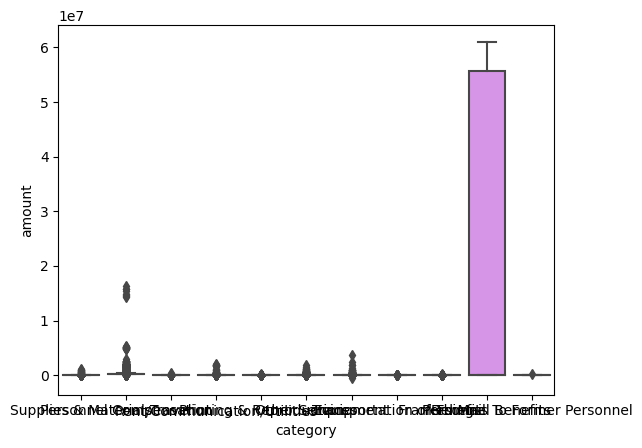

In [811]:
sum_by_cat = summ_Q116toQ417_df.groupby('category').sum().sort_values(by='amount', ascending=False).reset_index()
top_10_cats_by_amt = sum_by_cat.iloc[0:11,0]
top_10_cats_df = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['category'].isin(top_10_cats_by_amt)]
#sns.boxplot(x='category', y='amount', data=sum_by_cat.head(10))
fig,ax = plt.subplots()
sns.boxplot(x='category', y='amount', data=top_10_cats_df)
# add title , fix x range
# xlabs = sum_by_cat['category']
# ax.set_xticklabels(xlabs,rotation=45)
pass

#### number of expenses by category (hist) : 

##### top 10 categories by number (count) of expenses: 

In [812]:
count_by_cat = summ_Q116toQ417_df[['category','amount']].groupby('category').count().sort_values(by='amount', ascending=False).reset_index()
#count_by_cat.rename('amount','count')
count_by_cat.iloc[0:11,0]

0                   Other Services
1             Supplies & Materials
2     Rent/Communication/Utilities
3                        Equipment
4           Personnel Compensation
5                           Travel
6          Printing & Reproduction
7                     Franked Mail
8         Transportation of Things
9               Personnel Benefits
10    Benefits To Former Personnel
Name: category, dtype: object

In [815]:
#count_by_cat.iloc[0:11,0]
# #sns.boxplot(x='category', y='amount', data=sum_by_cat.head(10))
# ax, fig = plt.subplots(
# sns.boxplot(x='category', y='amount', data=summ_Q116toQ417_df.loc[summ_Q116toQ417_df['category'].isin(count_by_cat.iloc[0:6,0])])
# # # add title , fix x range
# # plt.set_xticks(rotation=45)
# pass

In [816]:
# fig,ax1 = plt.subplots()
# top_5_cats_by_count = count_by_cat.iloc[0:6,0]
# top_5_df = summ_Q116toQ417_df_no_neg.loc[summ_Q116toQ417_df['category'].isin(top_5_cats_by_count)]
# top_5_df.assign(index=top_5_df.groupby('category').cumcount()).pivot('index','category','amount').plot(kind='box',ax=ax1)
# fig.set_xlabels(rotation=45)
# pass

##### bottom 10 categories by number (count) of expenses: 

In [817]:
# count_by_cat = summ_Q116toQ417_df_no_neg[['category','amount']].groupby('category').count().sort_values(by='amount', ascending=False).reset_index()
# count_by_cat.rename('amount','count')
count_by_cat.tail(10)

,category,amount
2,Rent/Communication/Utilities,4117
3,Equipment,4113
4,Personnel Compensation,3942
5,Travel,3919
6,Printing & Reproduction,3883
7,Franked Mail,3574
8,Transportation of Things,188
9,Personnel Benefits,18
10,Benefits To Former Personnel,4
11,Insurance Claims & Indemnities,4


In [ ]:
summ_Q116toQ417_df.to_csv("project_2_summary_data/summ_clean_120622.csv")


## CLEANING/FIXING CONGRESS ID DATASET
(supplementary dataset (representative ID, party, name, etc.) to join with expense data

In [818]:
bioguide_reps_20152019_df = pd.read_json('bioguide_reps_20152019.json')
bioguide_reps_20152019_df.shape

(508, 13)

- original (raw) dataset dimensions: 508 rows, 13 columns

In [700]:
bioguide_reps_20152019_df.columns

Index(['id', 'givenName', 'familyName', 'unaccentedGivenName',
       'unaccentedFamilyName', 'birthYear', 'deathYear', 'congresses',
       'middleName', 'unaccentedMiddleName', 'nickName', 'honorificSuffix',
       'honorificPrefix'],
      dtype='object')

In [701]:
bioguide_reps_20152019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    508 non-null    object 
 1   givenName             508 non-null    object 
 2   familyName            508 non-null    object 
 3   unaccentedGivenName   508 non-null    object 
 4   unaccentedFamilyName  508 non-null    object 
 5   birthYear             508 non-null    int64  
 6   deathYear             17 non-null     float64
 7   congresses            508 non-null    object 
 8   middleName            195 non-null    object 
 9   unaccentedMiddleName  194 non-null    object 
 10  nickName              23 non-null     object 
 11  honorificSuffix       26 non-null     object 
 12  honorificPrefix       2 non-null      object 
dtypes: float64(1), int64(1), object(11)
memory usage: 51.7+ KB


- no missing values in the necessary fields (id, given & family name, congresses)
- given that some of the individuals in the ID dataset have the date of death field completed, this source lists previous congresspeople as well as current ones
- there are some missing values for potentially relevant fields like "middleName", but for now it makes sense to wait to check these until after the data is filtered down to the current representatives in the main df (especially because the older entries for historical congress members might be more likely to be missing bio info. 

In [702]:
# check that the ID numbers in the ID the all unique
len(bioguide_reps_20152019_df.id.unique())

508

- looks good!

In [703]:
# do the bioguide values in the main df resmeble the IDs in the ID dataset? 
summ_Q116toQ417_df.id.unique()[0:10]

array([nan, 'A000374', 'A000370', 'A000055', 'A000371', 'A000372',
       'A000367', 'A000369', 'A000373', 'B001291'], dtype=object)

In [191]:
len(summ_Q116toQ417_df.id.unique())

507

- the number of unique ids in each df almost match (508 in the id data vs. 506 (excluding Nan) in the main one. I'll need to check out these discrepancies ones this data has been cleaned. 

In [704]:
# check out the "congresses" column
bioguide_reps_20152019_df.congresses.value_counts()

[{'position': 'Representative', 'congressNumber': 115, 'stateName': 'CA', 'parties': ['Democrat']}, {'position': 'Representative', 'congressNumber': 116, 'stateName': 'CA', 'parties': ['Democrat']}, {'position': 'Representative', 'congressNumber': 117, 'stateName': 'CA', 'parties': ['Democrat'], 'electionCirca': False}]                                                                                                                                                                                                                                                                                                                                                                                                                5
[{'position': 'Representative', 'congressNumber': 113, 'stateName': 'CA', 'parties': ['Democrat']}, {'position': 'Representative', 'congressNumber': 114, 'stateName': 'CA', 'parties': ['Democrat']}, {'position': 'Representative', 'congressNumber': 115, 'stateName': 'CA', 'part

- It looks like some of the information we want to use to categorize the different representatives (parties, stateName, position (Representative or Senator) is included in this "congresses" column, so we will want to include it with the columns to join to the main dataset. electionDate might be useful as well (to calculate tenure as a variable). 
- The column is currently string type, but the syntax resembles a dictionary. On closer inspection, it appears that the repetitive strucutre of some entries are recording multiple terms (for re-elected members). This might be cool to use in the analysis if there's time (e.g., is there a meaningful relationship between the number of terms a Rep. has served and amounts/types of office expenditures? 

In [705]:
#find longest entry
congresses_col = bioguide_reps_20152019_df.congresses
congresses_list = congresses_col.to_list()
max(congresses_list,key=len)

[{'position': 'Representative',
  'congressNumber': 95,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 102,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 114,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 97,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 111,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 101,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 107,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 112,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumber': 100,
  'stateName': 'MI',
  'parties': ['Democrat']},
 {'position': 'Representative',
  'congressNumbe

- longest amount of terms served by an individual rep is 26! is that even possible?

In [706]:
# first, grab only last (most recent) item in each entry
congresses_list = congresses_col.to_list()
congresses_list_last_entry = [i[-1] for i in congresses_list]
len(congresses_list_last_entry) 

508

In [707]:
congresses_list_last_entry[0]

{'position': 'Representative',
 'congressNumber': 116,
 'stateName': 'LA',
 'parties': ['Republican']}

In [708]:
#  make new cols for position, last_congress_num, state_name, party: 
# *there's gotta be a prettier way to do this!
position_list = []
for i in range(len(congresses_list_last_entry)): 
    position = list(congresses_list_last_entry[i].values())[0]
    position_list.append(position)
print("position list len: ", len(position_list))

last_congress_num_list = []
for i in range(len(congresses_list_last_entry)): 
    congress_num = list(congresses_list_last_entry[i].values())[1]
    last_congress_num_list.append(congress_num)
print("congress list len: ", len(last_congress_num_list))

state_list = []
for i in range(len(congresses_list_last_entry)): 
    state = list(congresses_list_last_entry[i].values())[2]
    state_list.append(state)
print("state list len: ", len(state_list))

party_list = []
for i in range(len(congresses_list_last_entry)): 
    party = list(congresses_list_last_entry[i].values())[3]
    party_list.append(party)
print("party list len: ", len(party_list))


position list len:  508
congress list len:  508
state list len:  508
party list len:  508


In [709]:
#fix party col- individual value still list type
party_list[0]
party_list_2 = [p[0] for p in party_list]
party_list_2[0]

'Republican'

In [710]:
# assign new cols to df
position_col = pd.Series(position_list)
party_col = pd.Series(party_list_2)
state_col = pd.Series(state_list)
last_congress_num_col = pd.Series(last_congress_num_list)

bioguide_reps_20152019_df = bioguide_reps_20152019_df.assign(position=position_col,
                                                             party = party_col,
                                                             state = state_col,
                                                             last_congress_num = last_congress_num_col)
bioguide_reps_20152019_df.head()

,id,givenName,familyName,unaccentedGivenName,unaccentedFamilyName,birthYear,deathYear,congresses,middleName,unaccentedMiddleName,nickName,honorificSuffix,honorificPrefix,position,party,state,last_congress_num
0,A000374,Ralph,Abraham,Ralph,Abraham,1954,NaN,"[{'position': 'Representative', 'congressNumbe...",NaN,NaN,NaN,NaN,NaN,Representative,Republican,LA,116
1,A000370,Alma,Adams,Alma,Adams,1946,NaN,"[{'position': 'Representative', 'congressNumbe...",NaN,NaN,NaN,NaN,NaN,Representative,Democrat,NC,117
2,A000055,Robert,Aderholt,Robert,Aderholt,1965,NaN,"[{'position': 'Representative', 'congressNumbe...",NaN,NaN,NaN,NaN,NaN,Representative,Republican,AL,117
3,A000371,Peter,Aguilar,Peter,Aguilar,1979,NaN,"[{'position': 'Representative', 'congressNumbe...",Rey,Rey,NaN,NaN,NaN,Representative,Democrat,CA,117
4,A000372,Rick,Allen,Rick,Allen,1951,NaN,"[{'position': 'Representative', 'congressNumbe...",W.,W.,NaN,NaN,NaN,Representative,Republican,GA,117


In [199]:
# save file of data before dropping unused columns 
bioguide_reps_20152019_df.to_csv("project_2_summary_data/bioguide_reps_20152019_df_allcols.csv")
# may need to re-check congresses col for sanity checks etc. 

In [711]:
# drop unused columns 
bioguide_reps_20152019_df.drop(['unaccentedGivenName','unaccentedFamilyName',
         'birthYear','deathYear','congresses',
         'unaccentedMiddleName','last_congress_num'], axis=1,inplace=True)
bioguide_reps_20152019_df.head()

,id,givenName,familyName,middleName,nickName,honorificSuffix,honorificPrefix,position,party,state
0,A000374,Ralph,Abraham,NaN,NaN,NaN,NaN,Representative,Republican,LA
1,A000370,Alma,Adams,NaN,NaN,NaN,NaN,Representative,Democrat,NC
2,A000055,Robert,Aderholt,NaN,NaN,NaN,NaN,Representative,Republican,AL
3,A000371,Peter,Aguilar,Rey,NaN,NaN,NaN,Representative,Democrat,CA
4,A000372,Rick,Allen,W.,NaN,NaN,NaN,Representative,Republican,GA


In [712]:
# rename rest of cols
dict = {'givenName': 'first_name',
        'familyName': 'last_name',
        'middleName': 'middle_name',
        'nickName': 'nickname',
        'honorificSuffix': 'suffix',
        'honorificPrefix': 'prefix'
       }
bioguide_reps_20152019_df.rename(columns=dict,inplace=True)
bioguide_reps_20152019_df.head()

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
0,A000374,Ralph,Abraham,NaN,NaN,NaN,NaN,Representative,Republican,LA
1,A000370,Alma,Adams,NaN,NaN,NaN,NaN,Representative,Democrat,NC
2,A000055,Robert,Aderholt,NaN,NaN,NaN,NaN,Representative,Republican,AL
3,A000371,Peter,Aguilar,Rey,NaN,NaN,NaN,Representative,Democrat,CA
4,A000372,Rick,Allen,W.,NaN,NaN,NaN,Representative,Republican,GA


In [713]:
# final data checks
bioguide_reps_20152019_df.info()
# --> looks good: all necessary fields have no missing values, and only non-string column is last_congress_num

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           508 non-null    object
 1   first_name   508 non-null    object
 2   last_name    508 non-null    object
 3   middle_name  195 non-null    object
 4   nickname     23 non-null     object
 5   suffix       26 non-null     object
 6   prefix       2 non-null      object
 7   position     508 non-null    object
 8   party        508 non-null    object
 9   state        508 non-null    object
dtypes: object(10)
memory usage: 39.8+ KB


In [714]:
bioguide_reps_20152019_df.to_csv("bioguide_reps_20152019_df_final.csv")

#### After the id data has been checked, add ids to expense rows for offices of individual representatives in main expenditure df (before dropping committee/group entries) 

In [204]:
unique_summ_ids = summ_Q116toQ417_df.loc[summ_Q116toQ417_df['id'].notnull(),'id'].unique()
unique_summ_ids

array(['A000374', 'A000370', 'A000055', 'A000371', 'A000372', 'A000367',
       'A000369', 'A000373', 'B001291', 'B001269', 'B001282', 'B000213',
       'B001270', 'B001281', 'B000287', 'B001271', 'B001287', 'B001292',
       'B001257', 'B001293', 'B001250', 'B000490', 'B001273', 'B001243',
       'B001294', 'B000574', 'B001278', 'B001245', 'B001295', 'B001255',
       'B001296', 'B000755', 'B001227', 'B001290', 'B001283', 'B001274',
       'B001284', 'B000911', 'B001285', 'B001260', 'B001297', 'B001275',
       'B001248', 'B001286', 'B001251', 'B001289', 'C000059', 'C001036',
       'C001037', 'C001097', 'C001083', 'C001072', 'C001103', 'C001051',
       'C001090', 'C001066', 'C001091', 'C000266', 'C001076', 'C001080',
       'C001084', 'C001101', 'C001067', 'C001102', 'C001049', 'C001061',
       'C000537', 'C001077', 'C001068', 'C001053', 'C001092', 'C001093',
       'C001105', 'C001062', 'C001078', 'C000714', 'C001094', 'C000754',
       'C001059', 'C001106', 'C001069', 'C001096', 

In [715]:
# check office names 
len(summ_Q116toQ417_df.office.sort_values().unique()) # 531
#summ_Q116toQ417_df.office.sort_values().unique()

1209

#### based on the names in this list, a few need to be checked to see if they represent individual members rather than groups: 
source: https://history.house.gov/People/Office/Minority-Leaders/
- 'HON. 13TH DISTRICT OF MICHIGAN': either John Conyers, Jr. Democrat, MI, 113th-115th (2013-2017) OR Brenda Jones, Democrat, MI, 115th (2017-2018)
- 'HON. 18TH DISTRICT OF PENNSYLVANIA': either Tim Murphy, Republican, PA, 108th-115th (2003-2017) OR ???
- 'HON. 8TH DISTRICT OF ARIZONA': Trent Franks, Republican, AZ, 113th-115th (2013-2017) 
- 'OFFICE OF THE SPEAKER' (2016): Paul D. Ryan, Republican, WI, 115th (2015–2017)
- 'OFFICE OF THE MAJORITY LEADER': Kevin McCarthy, Republican, CA, 114th (2015–2017)
- 'OFFICE OF THE MINORITY LEADER': Nancy Pelosi, Democrat, CA, 114th (2015–2017)
- 'OFFICE OF THE MAJORITY WHIP': Steve Scalise, Republican, LA, 114th (2015–2017)
- 'OFFICE OF THE MINORITY WHIP': Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017)
- '2017 OFFICE OF THE SPEAKER' (2017): Paul D. Ryan, Republican, WI, 115th (2017–2019)
- '2017 OFFICE OF THE MAJORITY LEADER': Kevin McCarthy, Republican, CA, 115th (2017–2019)
- '2017 OFFICE OF THE MINORITY LEADER': Nancy Pelosi, Democrat, CA, 115th (2017–2019)
- '2017 OFFICE OF THE MAJORITY WHIP':  Steve Scalise, Republican, LA,  115th (2017–2019)
- '2017 OFFICE OF THE MINORITY WHIP': Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017)
 

In [241]:
# make list of office to clean & keep in data, then subset clean expense data
keep_offices_list = ['HON. 13TH DISTRICT OF MICHIGAN', #either John Conyers, Jr. Democrat, MI, 113th-115th (2013-2017) OR Brenda Jones, Democrat, MI, 115th (2017-2018)
                     'HON. 18TH DISTRICT OF PENNSYLVANIA', # either Tim Murphy, Republican, PA, 108th-115th (2015-2017) OR ???
                     'HON. 8TH DISTRICT OF ARIZONA', #Trent Franks, Republican, AZ, 113th-115th (2013-2017) 
                     'OFFICE OF THE SPEAKER', # (2016): #Paul D. Ryan, Republican, WI, 115th (2015–2017)
                     'OFFICE OF THE MAJORITY LEADER', #Kevin McCarthy, Republican, CA, 114th (2015–2017)
                     'OFFICE OF THE MINORITY LEADER', #Nancy Pelosi, Democrat, CA, 114th (2015–2017)
                     'OFFICE OF THE MAJORITY WHIP',  #Steve Scalise, Republican, LA, 114th (2015–2017)
                     'OFFICE OF THE MINORITY WHIP', # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017)
                     '2017 OFFICE OF THE SPEAKER', # (2017): #Paul D. Ryan, Republican, WI, 115th (2017–2019)
                     '2017 OFFICE OF THE MAJORITY LEADER', #Kevin McCarthy, Republican, CA, 115th (2017–2019)
                     '2017 OFFICE OF THE MINORITY LEADER', #Nancy Pelosi, Democrat, CA, 115th (2017–2019)
                     '2017 OFFICE OF THE MAJORITY WHIP',  #Steve Scalise, Republican, LA,  115th (2017–2019)
                     '2017 OFFICE OF THE MINORITY WHIP']  # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017)


In [242]:
party_mask = (summ_Q116toQ417_df['office'].isin(keep_offices_list)) | (summ_Q116toQ417_df['id'].notnull())
summ_party = summ_Q116toQ417_df.loc[party_mask]
summ_party.shape

(28598, 7)

In [243]:
summ_party[summ_party['office']=='OFFICE OF THE SPEAKER']

,id,office,year,quarter,year_quarter,category,amount
0,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Supplies & Materials,380.00
1,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Personnel Compensation,1400132.67
2,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Travel,47.27
3,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Rent/Communication/Utilities,102.65
4,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Printing & Reproduction,802.20
5,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Other Services,2576.71
6,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Supplies & Materials,26335.54
7,NaN,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Equipment,115.54
0,NaN,OFFICE OF THE SPEAKER,2016,Q2,2016Q2,Supplies & Materials,0.00
1,NaN,OFFICE OF THE SPEAKER,2016,Q2,2016Q2,Personnel Compensation,1470009.32


look up ids for each of these offices: 

In [212]:
# 'OFFICE OF THE SPEAKER', '2017 OFFICE OF THE SPEAKER': #Paul D. Ryan, Republican, WI, 115th (2015–2017)
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Ryan"]

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
408,R000570,Paul,Ryan,D.,NaN,NaN,NaN,Representative,Republican,WI
409,R000577,Timothy,Ryan,J.,NaN,NaN,NaN,Representative,Democrat,OH


In [213]:
# 'OFFICE OF THE MAJORITY LEADER & '2017 OFFICE OF THE MAJORITY LEADER', #Kevin McCarthy, Republican, CA, 115th (2017–2019 
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "McCarthy"]

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
305,M001165,Kevin,McCarthy,NaN,NaN,NaN,NaN,Representative,Republican,CA


In [214]:
# 'OFFICE OF THE MINORITY LEADER' & '2017 OFFICE OF THE MINORITY LEADER': Nancy Pelosi, Democrat, CA, 115th (2017–2019)
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Pelosi"]

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
359,P000197,Nancy,Pelosi,NaN,NaN,NaN,Ms.,Representative,Democrat,CA


In [215]:
#'OFFICE OF THE MAJORITY WHIP' & '2017 OFFICE OF THE MAJORITY WHIP': Steve Scalise, Republican, LA, 114th (2015–2017)
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Scalise"]

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
415,S001176,Steve,Scalise,NaN,NaN,NaN,NaN,Representative,Republican,LA


In [216]:
#'OFFICE OF THE MINORITY WHIP' & '2017 OFFICE OF THE MINORITY WHIP': # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Hoyer"]

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
216,H000874,Steny,Hoyer,Hamilton,NaN,NaN,NaN,Representative,Democrat,MD


In [820]:
summ_party.office.sort_values().unique()[0:10]

array(['HON. A. DONALD MCEACHIN', 'HON. A. DREW FERGUSON IV',
       'HON. ADAM B. SCHIFF', 'HON. ADAM KINZINGER', 'HON. ADAM SMITH',
       'HON. ADRIAN SMITH', 'HON. ADRIANO ESPAILLAT', 'HON. AL GREEN',
       'HON. AL LAWSON  JR.', 'HON. ALAN GRAYSON'], dtype=object)

In [246]:
# remove '2017 ' from some rows 
mask = summ_party['office'].str.contains('2017 ')
summ_party.loc[mask]
summ_party.loc[:,'office'] = summ_party.loc['office'].str.replace('2017 ','')

,id,office,year,quarter,year_quarter,category,amount


In [668]:
# there's gotta be a more efficient way to do this... (map?)
#'OFFICE OF THE SPEAKER':'R000570', # Paul D. Ryan, Republican, WI, 115th (2015–2017)
mask = summ_party['office']=='OFFICE OF THE SPEAKER'
summ_party.loc[mask,'id']= 'R000570'
# check: summ_party.loc[mask,'id']

In [667]:
#'OFFICE OF THE MAJORITY LEADER':'M001165', #Kevin McCarthy, Republican, CA, 114th (2015–2017)
mask = summ_party['office']=='OFFICE OF THE MAJORITY LEADER'
summ_party.loc[mask,'id']= 'M001165'
# check: summ_party.loc[mask,'id']

In [666]:
# 'OFFICE OF THE MINORITY LEADER':'P000197', #Nancy Pelosi, Democrat, CA, 115th (2017–2019)
mask = summ_party['office']=='OFFICE OF THE MINORITY LEADER'
summ_party.loc[mask,'id']= 'P000197'
# check: summ_party.loc[mask,'id']

In [665]:
# 'OFFICE OF THE MAJORITY WHIP':'S001176', #Steve Scalise, Republican, LA, 114th (2015–2017)
mask = summ_party['office']=='OFFICE OF THE MAJORITY WHIP'
summ_party.loc[mask,'id']= 'S001176'
# check: summ_party.loc[mask,'id']

In [669]:
# 'OFFICE OF THE MINORITY WHIP':'H000874', # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017
mask = summ_party['office']=='OFFICE OF THE MINORITY WHIP'
summ_party.loc[mask,'id']= 'H000874'
# check: summ_party.loc[mask,'id']

check any missing ids: 

In [254]:
summ_party.id.isna().sum()

0

### MERGE: 

In [255]:
# RENAME COLUMN FOR JOIN
bioguide_reps_20152019_df['id'] = bioguide_reps_20152019_df['id']
bioguide_reps_20152019_df.columns

Index(['id', 'first_name', 'last_name', 'middle_name', 'nickname', 'suffix',
       'prefix', 'position', 'party', 'state'],
      dtype='object')

In [256]:
merge_df = pd.merge(summ_party, bioguide_reps_20152019_df, how="left", on = "id")
merge_df.head()

,id,office,year,quarter,year_quarter,category,amount,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state
0,R000570,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Supplies & Materials,380.00,Paul,Ryan,D.,NaN,NaN,NaN,Representative,Republican,WI
1,R000570,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Personnel Compensation,1400132.67,Paul,Ryan,D.,NaN,NaN,NaN,Representative,Republican,WI
2,R000570,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Travel,47.27,Paul,Ryan,D.,NaN,NaN,NaN,Representative,Republican,WI
3,R000570,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Rent/Communication/Utilities,102.65,Paul,Ryan,D.,NaN,NaN,NaN,Representative,Republican,WI
4,R000570,OFFICE OF THE SPEAKER,2016,Q1,2016Q1,Printing & Reproduction,802.20,Paul,Ryan,D.,NaN,NaN,NaN,Representative,Republican,WI


In [257]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28598 entries, 0 to 28597
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28598 non-null  object 
 1   office        28598 non-null  object 
 2   year          28598 non-null  object 
 3   quarter       28598 non-null  object 
 4   year_quarter  28598 non-null  object 
 5   category      28598 non-null  object 
 6   amount        28598 non-null  float64
 7   first_name    28159 non-null  object 
 8   last_name     28159 non-null  object 
 9   middle_name   10692 non-null  object 
 10  nickname      1337 non-null   object 
 11  suffix        1406 non-null   object 
 12  prefix        119 non-null    object 
 13  position      28159 non-null  object 
 14  party         28159 non-null  object 
 15  state         28159 non-null  object 
dtypes: float64(1), object(15)
memory usage: 3.7+ MB


what's going on with the ~500 missing party values? 

In [258]:
merge_no_party = merge_df.loc[merge_df['party'].isnull()]
merge_no_party.office.unique()

array(['HON. MADELEINE Z. BORDALLO', 'HON. ELEANOR HOLMES NORTON',
       'HON. PEDRO R. PIERLUISI', 'HON. STACEY PLASKETT',
       'HON. AMATA COLEMAN RADEWAGEN', 'HON. GREGORIO SABLAN',
       'HON. JENNIFFER GONZALEZ-COLON', 'HON. LISA BLUNT ROCHESTER',
       'HON. MICHELLE LUJAN GRISHAM', 'HON. CATHY MCMORRIS RODGERS'],
      dtype=object)

In [664]:
# check total expenses
merge_no_party.groupby(['office','year_quarter']).sum()

amount
office                        year_quarter           
HON. AMATA COLEMAN RADEWAGEN  2016Q1        237338.89
                              2016Q2        280255.15
                              2016Q3        275903.98
                              2016Q4        356456.60
                              2017Q1        248515.93
                              2017Q2        304239.91
                              2017Q3        297379.27
                              2017Q4        404853.95
HON. CATHY MCMORRIS RODGERS   2017Q3        322399.96
                              2017Q4        334813.69
HON. ELEANOR HOLMES NORTON    2016Q1        289671.43
                              2016Q2        299988.31
                              2016Q3        309071.19
                              2016Q4        323966.56
                              2017Q1        280819.45
                              2017Q2        287778.02
                              2017Q3        302036.83
                              2017Q4        330556.99
HON. GREGORIO SABLAN          2016Q1        233565.55
                              2016Q2        235795.91
                              2016Q3        351400.61
                              2016Q4        341271.96
                              2017Q1        242713.52
                              2017Q2        281729.34
                              2017Q3        355170.22
                              2017Q4        361566.96
HON. JENNIFFER GONZALEZ-COLON 2017Q1        291072.30
                              2017Q3        355365.32
                              2017Q4        513290.19
HON. LISA BLUNT ROCHESTER     2017Q1        209897.10
                              2017Q3        251165.67
                              2017Q4        300505.22
HON. MADELEINE Z. BORDALLO    2016Q1        278143.44
                              2016Q2        289446.68
                              2016Q3        308424.93
                              2016Q4        322097.91
                              2017Q1        262747.86
                              2017Q2        283658.51
                              2017Q3        307528.48
                              2017Q4        357726.84
HON. MICHELLE LUJAN GRISHAM   2017Q3        301165.28
                              2017Q4        363794.34
HON. PEDRO R. PIERLUISI       2016Q1        332850.75
                              2016Q2        523768.34
                              2016Q3        317746.76
                              2016Q4        400881.92
HON. STACEY PLASKETT          2016Q1        285288.13
                              2016Q2        269530.95
                              2016Q3        227771.74
                              2016Q4        318223.40
                              2017Q1        219437.53
                              2017Q2        269471.18
                              2017Q3        312844.76
                              2017Q4        341943.64

- 10 reps missing party data - were these not in the original bioguide df? 

In [259]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Bordallo']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [260]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Pierluisi']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [261]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Norton']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [262]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Plaskett']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [263]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Radewagen']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [264]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Sablan']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [265]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Rochester']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [266]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Grisham']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


In [267]:
bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name']=='Rodgers']

,id,first_name,last_name,middle_name,nickname,suffix,prefix,position,party,state


SOURCE: congress.gov  
- **Delegate Madeleine Z. Bordallo** (2003-2019) 
    - Party 	Democratic
    - House 	Guam, District At Large 108th-115th (2003-2019) 
- **Delegate Eleanor Holmes Norton** (1991 - Present)
    - Party 	Democratic
    - House 	District of Columbia, District At Large 102nd-117th (1991-Present) 
- **Pedro Pierluisi** (2009-2017)
    - Office: Resident Commissioner
    - State/Territory: Puerto Rico
    - Party: New Progressive 
- **Delegate Stacey E. Plaskett** (2015 - Present)
    - Party 	Democratic
    - House 	Virgin Islands, District At Large 114th-117th (2015-Present) 
- **Delegate Aumua Amata Coleman Radewagen (2015-present)**
    - Party 	Republican
    - House 	American Samoa, District At Large 114th-117th (2015-Present)
- **Delegate Gregorio Kilili Camacho Sablan** (2009 - Present)
    - Party 	Democratic
    - House 	Northern Mariana Islands, District At Large 111th-117th (2009-Present) 
- **Resident Commissioner Jenniffer González-Colón** (2017 - Present)
    - Party 	Republican
    - House 	Puerto Rico, District At Large 115th-117th (2017-Present) 
- **Representative Lisa Blunt Rochester** (2017 - Present)
    - Party 	Democratic
    - House 	Delaware, 115th-117th (2017-Present) 
- **Representative Michelle Lujan Grisham**
    - Party: Democrat
    - State/Territory: New Mexico
- **Representative Cathy McMorris Rodgers** (2005-Present) 
    - Party 	Republican
    - House 	Washington, District 5 

In [273]:
# manually add party data: 
merge_df['party'].unique() # check values

array(['Republican', 'Democrat', nan], dtype=object)

In [276]:
# manually add party & state data: 
merge_df['party'].unique() # check values
# 'HON. MADELEINE Z. BORDALLO'
mask = merge_df['office']=='HON. MADELEINE Z. BORDALLO'
merge_df.loc[mask,'party']= 'Democrat'
merge_df.loc[mask,'state']= 'DAL Guam' # DAL = "district at large" 

#'HON. ELEANOR HOLMES NORTON'
mask = merge_df['office']=='HON. ELEANOR HOLMES NORTON'
merge_df.loc[mask,'party']= 'Democrat'
merge_df.loc[mask,'state']= 'DAL DC'

#'HON. PEDRO R. PIERLUISI'
mask = merge_df['office']=='HON. PEDRO R. PIERLUISI'
merge_df.loc[mask,'party']= 'New Progressive'
merge_df.loc[mask,'state']= 'DAL Puerto Rico' 

#'HON. STACEY PLASKETT',
mask = merge_df['office']=='HON. STACEY PLASKETT'
merge_df.loc[mask,'party']= 'Democrat'
merge_df.loc[mask,'state']= 'DAL Virgin Islands'

#'HON. AMATA COLEMAN RADEWAGEN'
mask = merge_df['office']=='HON. AMATA COLEMAN RADEWAGEN'
merge_df.loc[mask,'party']= 'Republican'
merge_df.loc[mask,'state']= 'DAL American Samoa' 

# 'HON. GREGORIO SABLAN',
mask = merge_df['office']=='HON. GREGORIO SABLAN'
merge_df.loc[mask,'party']= 'Democrat'
merge_df.loc[mask,'state']='DAL Northern Mariana Islands'

# 'HON. JENNIFFER GONZALEZ-COLON'
mask = merge_df['office']=='HON. JENNIFFER GONZALEZ-COLON'
merge_df.loc[mask,'party']= 'Republican'
merge_df.loc[mask,'state']= 'DAL Puerto Rico' 

# 'HON. LISA BLUNT ROCHESTER'
mask = merge_df['office']=='HON. LISA BLUNT ROCHESTER'
merge_df.loc[mask,'party']= 'Democrat'
merge_df.loc[mask,'state']= 'DE'

# 'HON. MICHELLE LUJAN GRISHAM'
mask = merge_df['office']=='HON. MICHELLE LUJAN GRISHAM'
merge_df.loc[mask,'party']= 'Democrat'
merge_df.loc[mask,'state']= 'NM'

#'HON. CATHY MCMORRIS RODGERS'
mask = merge_df['office']=='HON. CATHY MCMORRIS RODGERS'
merge_df.loc[mask,'party']= 'Republican'
merge_df.loc[mask,'state']= 'WA'

In [278]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28598 entries, 0 to 28597
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28598 non-null  object 
 1   office        28598 non-null  object 
 2   year          28598 non-null  object 
 3   quarter       28598 non-null  object 
 4   year_quarter  28598 non-null  object 
 5   category      28598 non-null  object 
 6   amount        28598 non-null  float64
 7   first_name    28159 non-null  object 
 8   last_name     28159 non-null  object 
 9   middle_name   10692 non-null  object 
 10  nickname      1337 non-null   object 
 11  suffix        1406 non-null   object 
 12  prefix        119 non-null    object 
 13  position      28159 non-null  object 
 14  party         28598 non-null  object 
 15  state         28598 non-null  object 
dtypes: float64(1), object(15)
memory usage: 3.7+ MB


In [284]:
merge_df.to_csv("project_2_summary_data/merge_df_120822")

- looks good!\
***SANITY CHECK***: total counts of reps for each party

In [301]:
#merge_df.groupby(['party','id']).count()
merge_df.id.groupby(merge_df['party']).count().reset_index(name='count')
# merge_df.party.unique()

,party,count
0,Democrat,12557
1,New Progressive,32
2,Republican,16009


In [305]:
merge_df[['party','office']].groupby('party').count()

,office
party,
Democrat,12557
New Progressive,32
Republican,16009


In [321]:
cnt_by_party_yr = merge_df.groupby(['party','year'])['id'].nunique().reset_index() #.rename('id'P
cnt_by_party_yr = cnt_by_party_yr.set_index('year').sort_values(by='year')
cnt_by_party_yr

,party,id
year,,
2016,Democrat,193
2016,New Progressive,1
2016,Republican,249
2017,Democrat,202
2017,Republican,249


In [322]:
cnt_by_party_yr.groupby('year').sum()

,id
year,
2016,443
2017,451


- looks about right (given that each year has a few RC/delegate representatives from districts at large like DC or Guam)

## VISUALIZATIONS 

In [384]:
reps_by_yr_state_2016 = reps_by_yr_state.loc[reps_by_yr_state['year']=='2016']

/var/folders/yl/yj1hlnzd3v7dx2jll1zhy2_m0000gn/T/ipykernel_1230/897999416.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



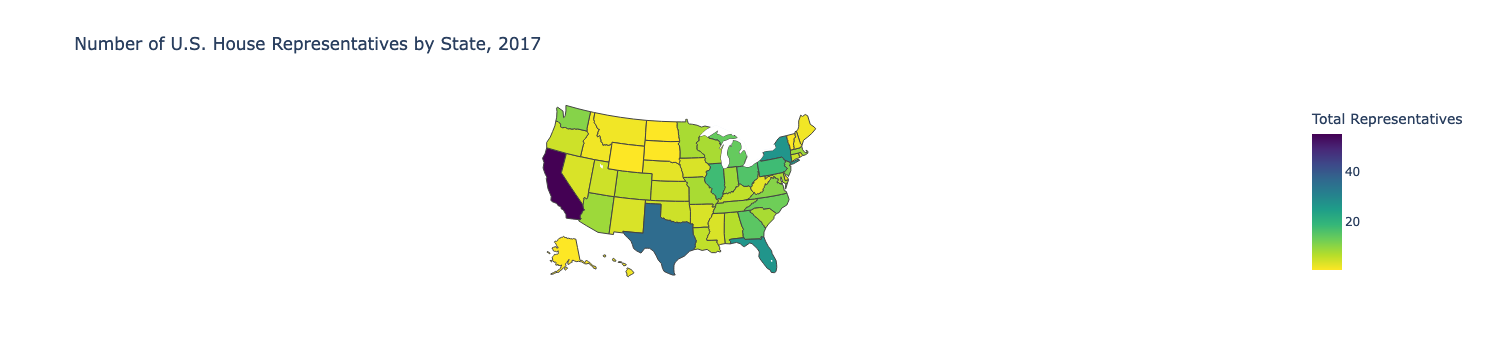

In [408]:
reps_by_yr_state_2017 = reps_by_yr_state.loc[reps_by_yr_state['year']=='2017']
reps_by_yr_state_2017_noDAL = reps_by_yr_state_2017.loc[~reps_by_yr_state_2017['state'].str.contains("DAL")]

reps_by_yr_state_2017_noDAL.rename(columns={'id':"Total Representatives"},inplace=True)

fig = px.choropleth(reps_by_yr_state_2017_noDAL,
                    locations='state', 
                    locationmode="USA-states", 
                    color="Total Representatives",
                    color_continuous_scale="Viridis_r", 
                    scope="usa",
                    title= 'Number of U.S. House Representatives by State, 2017') 
fig.show()

In [436]:
reps_by_yr_state= merge_df.groupby(['state','year'])['id'].nunique().reset_index()

In [671]:
DAL_table = reps_by_yr_state.loc[reps_by_yr_state['state'].str.contains("DAL")]
DAL_table = DAL_table.rename(columns = {'state':'District/Territory'})
DAL_table = DAL_table.set_index('District/Territory')
DAL_table['2016'] = DAL_table['id']
DAL_table['2017'] = DAL_table['id']
DAL_table = DAL_table.loc[DAL_table['year'] == '2016']
DAL_table.drop(columns="id", inplace=True)
DAL_table.drop(columns="year", inplace=True)
DAL_table.reset_index()
DAL_table

,2016,2017
District/Territory,,
DAL American Samoa,1,1
DAL DC,1,1
DAL Guam,1,1
DAL Northern Mariana Islands,1,1
DAL Puerto Rico,1,1
DAL Virgin Islands,1,1


In [673]:
#merge_test_df_no_fiscal = merge_test_df_no_fiscal.astype({'year': 'str'})
print(f"merge df shape: {merge_df.shape}")
merge_df_no_DAL = merge_df.loc[~merge_df['state'].str.contains("DAL")]
print(f"merge df no DAL shape: {merge_df_no_DAL.shape}")
#by_final = merge_df.groupby(['party','year','category']).sum().reset_index()

merge df shape: (28598, 16)
merge df no DAL shape: (28215, 16)


In [674]:
cnt_by_party_yr_qtr = merge_df_no_DAL.groupby(['party','year_quarter'])['id'].nunique().reset_index() #.rename('id'P
cnt_by_party_yr_qtr.rename(columns={'id':'total_reps'},inplace=True) #= cnt_by_party_yr_qtr.set_index('year').sort_values(by='year_quarter')

In [675]:
amt_by_party_yr_qtr= merge_df_no_DAL.groupby(['party','year_quarter']).sum().reset_index()
amt_by_party_yr_qtr['total_reps'] = cnt_by_party_yr_qtr['total_reps']
# ADD NEW COL FOR AVERAGE SPENDING/NUMBER OF REPS :
amt_by_party_yr_qtr['avg_amt_per_rep'] = amt_by_party_yr_qtr['amount']/amt_by_party_yr_qtr['total_reps']
amt_by_party_yr_qtr

,party,year_quarter,amount,total_reps,avg_amt_per_rep
0,Democrat,2016Q1,51173815.89,187,273656.769465
1,Democrat,2016Q2,56642165.95,187,302899.283155
2,Democrat,2016Q3,56651361.30,187,302948.456150
3,Democrat,2016Q4,63175151.88,189,334260.062857
4,Democrat,2017Q1,52819963.91,193,273678.569482
5,Democrat,2017Q2,58086573.46,194,299415.327113
6,Democrat,2017Q3,59298348.36,195,304094.094154
7,Democrat,2017Q4,69913924.73,195,358532.947333
8,Republican,2016Q1,65198334.85,246,265033.881504
9,Republican,2016Q2,72885695.97,247,295083.789352


In [676]:
amt_by_party_yr_qtr.rename(columns={'party':'Party'},inplace=True)

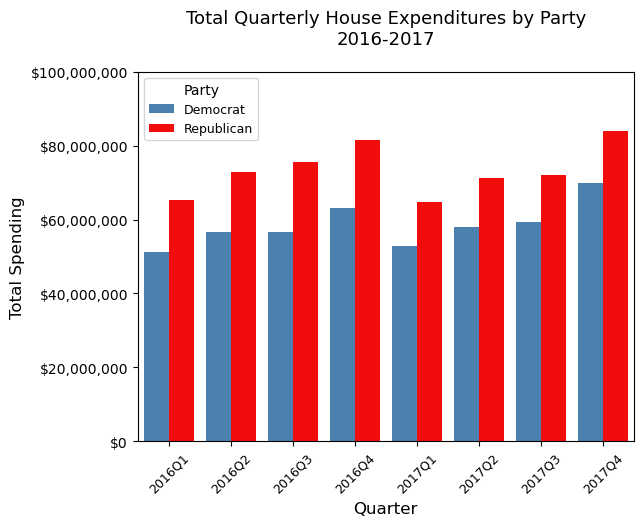

In [821]:
fig,ax = plt.subplots()
sns.barplot(x='year_quarter', y='amount', hue='Party', data=amt_by_party_yr_qtr, palette=['steelblue','red'],saturation=0.9)
plt.xticks(rotation=45, fontsize=9)
ax.set_ylabel('Total Spending',fontsize=12) 
yfmt = '${x:,.0f}' # add dollar signs/commas w/ tick formatter
ytick = mtick.StrMethodFormatter(yfmt)
ax.yaxis.set_major_formatter(ytick)
ax.set_ylim((0,100000000))
ax.set_xlabel('Quarter',fontsize=12)
ax.set_title('Total Quarterly House Expenditures by Party\n2016-2017',fontsize=13,pad=20)
pass

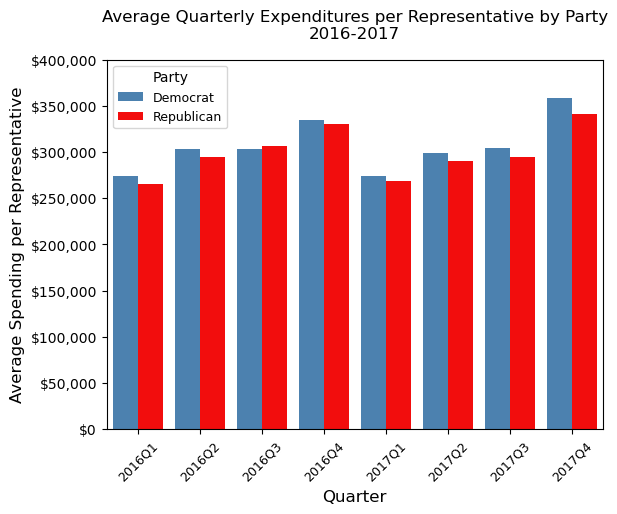

In [822]:
fig,ax = plt.subplots()
sns.barplot(x='year_quarter', y='avg_amt_per_rep', hue='Party', data=amt_by_party_yr_qtr, palette=['steelblue','red'],saturation=0.9)
plt.xticks(rotation=45, fontsize=9)
ax.set_ylabel('Average Spending per Representative',fontsize=12) 
yfmt = '${x:,.0f}' # add dollar signs/commas w/ tick formatter
ytick = mtick.StrMethodFormatter(yfmt)
ax.yaxis.set_major_formatter(ytick)
ax.set_ylim((0,400000))
ax.set_xlabel('Quarter',fontsize=12)
ax.set_title('Average Quarterly Expenditures per Representative by Party\n2016-2017',fontsize=12,pad=15)
pass

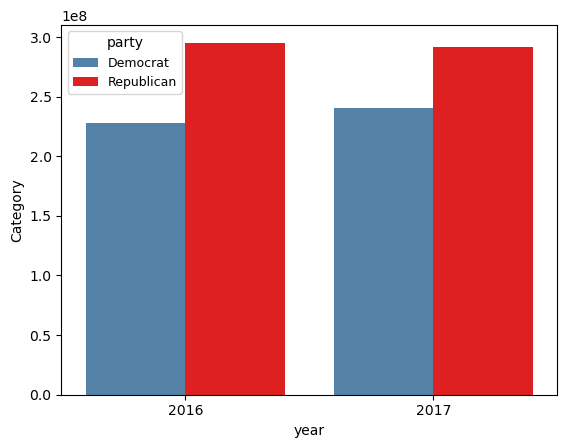

In [823]:
# plot non-DAL spending by party/year
by_qrt_party = merge_df_no_DAL.groupby(['party','year']).sum()
by_qrt_party = by_qrt_party.reset_index()
fig,ax = plt.subplots()
cats = by_final.category
sns.barplot(x='year', y='amount', hue='party', data=by_qrt_party, palette=['steelblue','red'])
ax.set_ylabel('Category')
pass

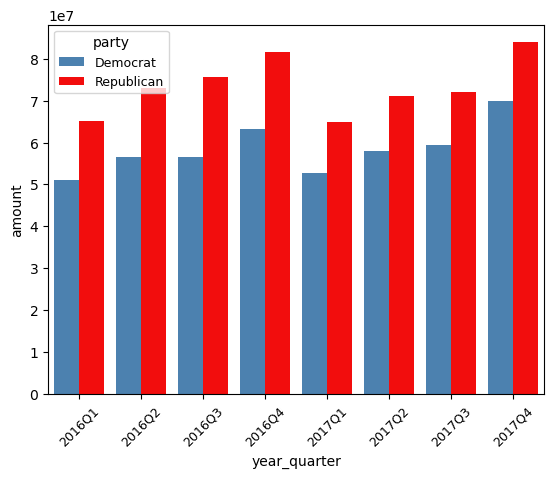

In [824]:
by_qrt_yr_party = merge_df_no_DAL.groupby(['party','year_quarter']).sum()
by_qrt_yr_party = by_qrt_yr_party.reset_index()
fig,ax = plt.subplots()
cats = by_final.category
sns.barplot(x='year_quarter', y='amount', hue='party', data=by_qrt_yr_party, palette=['steelblue','red'],saturation=0.9)
plt.xticks(rotation=45, fontsize=9)
pass

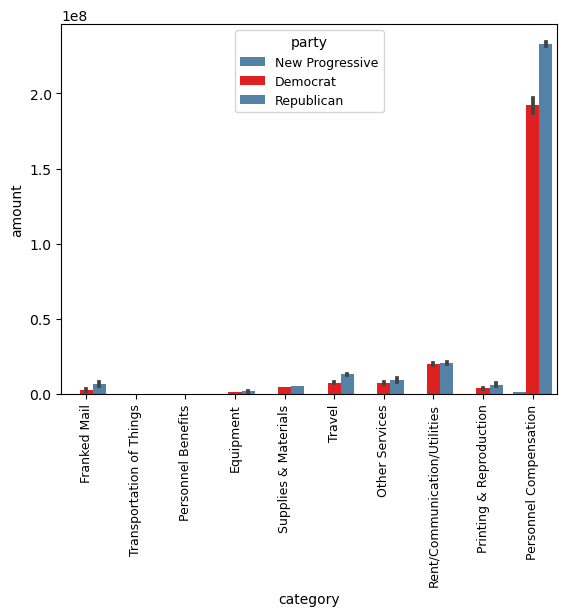

In [825]:
by_final = by_final.sort_values("amount")
fig,ax = plt.subplots()
cats = by_final.category
sns.barplot(x='category', y='amount', hue='party', data=by_final, palette=['steelblue','red'])
plt.xticks(rotation=90, fontsize=9)
plt.xticks(rotation=90, fontsize=9)
pass

In [826]:
by_cat_party = merge_df_no_DAL.groupby(['category','party','year']).sum()
by_cat_party = by_cat_party.fillna(0).unstack()
by_cat_party= by_cat_party.reset_index()
by_cat_party

category       party        amount              
year                                                    2016          2017
0                        Equipment    Democrat  8.961393e+05  1.368786e+06
1                        Equipment  Republican  1.518658e+06  1.830194e+06
2                     Franked Mail    Democrat  3.175533e+06  2.001799e+06
3                     Franked Mail  Republican  8.133960e+06  5.436337e+06
4                   Other Services    Democrat  6.132514e+06  7.789654e+06
5                   Other Services  Republican  7.976902e+06  1.064298e+07
6               Personnel Benefits    Democrat  3.114000e+03           NaN
7           Personnel Compensation    Democrat  1.835314e+08  1.937414e+08
8           Personnel Compensation  Republican  2.334278e+08  2.299178e+08
9          Printing & Reproduction    Democrat  4.094138e+06  3.020642e+06
10         Printing & Reproduction  Republican  6.961975e+06  5.134430e+06
11    Rent/Communication/Utilities    Democrat  1.887148e+07  2.027044e+07
12    Rent/Communication/Utilities  Republican  1.962818e+07  2.087222e+07
13            Supplies & Materials    Democrat  4.282723e+06  4.215815e+06
14            Supplies & Materials  Republican  5.189542e+06  4.834187e+06
15        Transportation of Things    Democrat  5.956290e+03  1.117640e+03
16        Transportation of Things  Republican  1.616820e+03  1.937150e+03
17                          Travel    Democrat  6.649507e+06  7.709150e+06
18                          Travel  Republican  1.239644e+07  1.323373e+07

In [830]:
by_cat_party.columns = ['category','party','2016 Total','2017 Total']
by_cat_party = by_cat_party.sort_values(by='2016 Total')
by_cat_party

,category,party,2016 Total,2017 Total
16,Transportation of Things,Republican,1.616820e+03,1.937150e+03
6,Personnel Benefits,Democrat,3.114000e+03,NaN
15,Transportation of Things,Democrat,5.956290e+03,1.117640e+03
0,Equipment,Democrat,8.961393e+05,1.368786e+06
1,Equipment,Republican,1.518658e+06,1.830194e+06
2,Franked Mail,Democrat,3.175533e+06,2.001799e+06
9,Printing & Reproduction,Democrat,4.094138e+06,3.020642e+06
13,Supplies & Materials,Democrat,4.282723e+06,4.215815e+06
14,Supplies & Materials,Republican,5.189542e+06,4.834187e+06
4,Other Services,Democrat,6.132514e+06,7.789654e+06


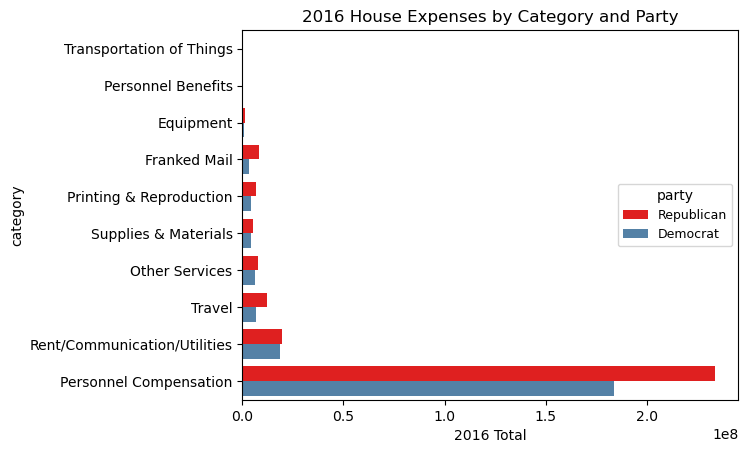

In [831]:
fig,ax = plt.subplots()
sns.barplot(y='category', x='2016 Total', hue='party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
ax.set_title('2016 House Expenses by Category and Party')
pass

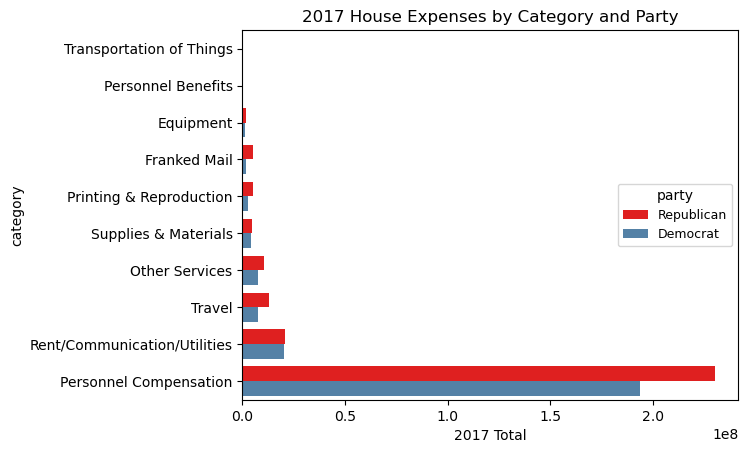

In [832]:
fig,ax = plt.subplots()
sns.barplot(y='category', x='2017 Total', hue='party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
ax.set_title('2017 House Expenses by Category and Party')
pass

### average rep spending by party: 

In [569]:
by_cat_party

,category,party,2016 Total,2017 Total
16,Transportation of Things,Republican,1.616820e+03,1.937150e+03
6,Personnel Benefits,Democrat,3.114000e+03,NaN
15,Transportation of Things,Democrat,5.956290e+03,1.117640e+03
0,Equipment,Democrat,8.961393e+05,1.368786e+06
1,Equipment,Republican,1.518658e+06,1.830194e+06
2,Franked Mail,Democrat,3.175533e+06,2.001799e+06
9,Printing & Reproduction,Democrat,4.094138e+06,3.020642e+06
13,Supplies & Materials,Democrat,4.282723e+06,4.215815e+06
14,Supplies & Materials,Republican,5.189542e+06,4.834187e+06
4,Other Services,Democrat,6.132514e+06,7.789654e+06


In [692]:
cnt_by_party_yr= merge_df_no_DAL.groupby(['party','year'])['id'].nunique().reset_index() #.rename('id'P
cnt_by_party_yr.rename(columns={'id':'total_reps'},inplace=True) #= cnt_by_party_yr_qtr.set_index('year').sort_values(by='year_quarter')
cnt_by_party_yr

,party,year,total_reps
0,Democrat,2016,189
1,Democrat,2017,198
2,Republican,2016,248
3,Republican,2017,247


In [834]:
by_cat_party['2016_avg_per_rep'] = np.where(by_cat_party['party']=='Republican', by_cat_party['2016 Total']/248, by_cat_party['2016 Total']/189)
by_cat_party

,category,party,2016 Total,2017 Total,2016_avg_per_rep
16,Transportation of Things,Republican,1.616820e+03,1.937150e+03,6.519435
6,Personnel Benefits,Democrat,3.114000e+03,NaN,16.476190
15,Transportation of Things,Democrat,5.956290e+03,1.117640e+03,31.514762
0,Equipment,Democrat,8.961393e+05,1.368786e+06,4741.477778
1,Equipment,Republican,1.518658e+06,1.830194e+06,6123.619839
2,Franked Mail,Democrat,3.175533e+06,2.001799e+06,16801.760317
9,Printing & Reproduction,Democrat,4.094138e+06,3.020642e+06,21662.104709
13,Supplies & Materials,Democrat,4.282723e+06,4.215815e+06,22659.911481
14,Supplies & Materials,Republican,5.189542e+06,4.834187e+06,20925.572903
4,Other Services,Democrat,6.132514e+06,7.789654e+06,32447.163757


In [573]:
by_cat_party['2017_avg_per_rep'] = np.where(by_cat_party['party']=='Republican', by_cat_party['2017 Total']/247, by_cat_party['2016 Total']/198)
by_cat_party

,category,party,2016 Total,2017 Total,2016_avg_per_rep,2017_avg_per_rep
16,Transportation of Things,Republican,1.616820e+03,1.937150e+03,6.545830,7.842713
6,Personnel Benefits,Democrat,3.114000e+03,NaN,15.727273,15.727273
15,Transportation of Things,Democrat,5.956290e+03,1.117640e+03,30.082273,30.082273
0,Equipment,Democrat,8.961393e+05,1.368786e+06,4525.956061,4525.956061
1,Equipment,Republican,1.518658e+06,1.830194e+06,6148.411822,7409.693360
2,Franked Mail,Democrat,3.175533e+06,2.001799e+06,16038.043939,16038.043939
9,Printing & Reproduction,Democrat,4.094138e+06,3.020642e+06,20677.463586,20677.463586
13,Supplies & Materials,Democrat,4.282723e+06,4.215815e+06,21629.915505,21629.915505
14,Supplies & Materials,Republican,5.189542e+06,4.834187e+06,21010.291822,19571.608583
4,Other Services,Democrat,6.132514e+06,7.789654e+06,30972.292677,30972.292677


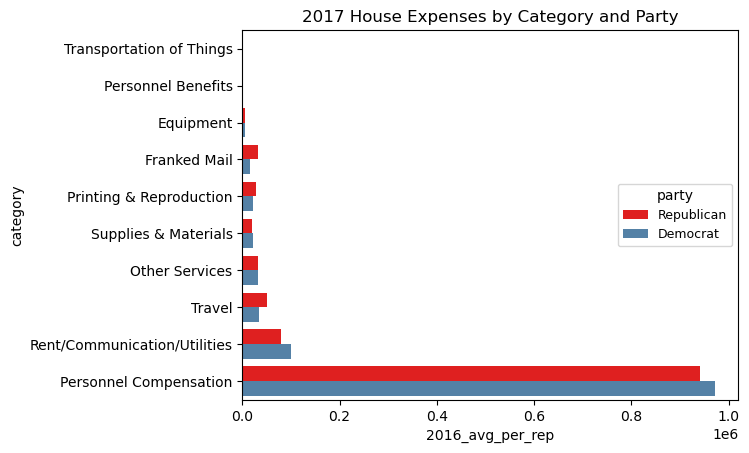

In [576]:
fig,ax = plt.subplots()
sns.barplot(y='category', x='2016_avg_per_rep', hue='party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
ax.set_title('2017 House Expenses by Category and Party')
pass

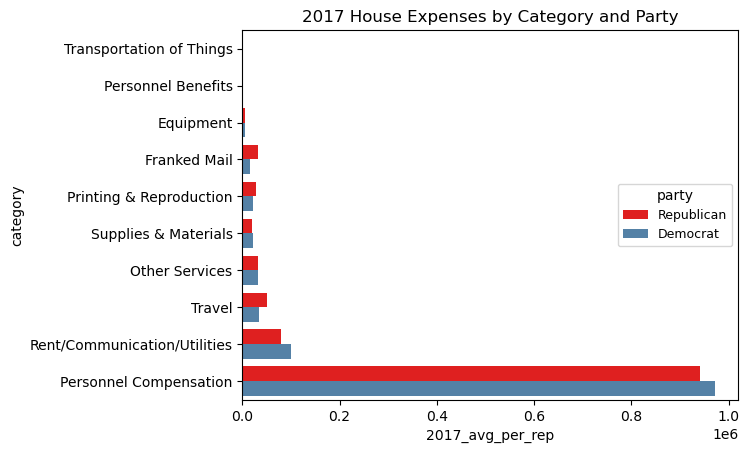

In [577]:
fig,ax = plt.subplots()
sns.barplot(y='category', x='2017_avg_per_rep', hue='party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
ax.set_title('2017 House Expenses by Category and Party')
pass

In [621]:
by_cat_party.rename(columns={'party':'Party'},inplace=True)

/var/folders/yl/yj1hlnzd3v7dx2jll1zhy2_m0000gn/T/ipykernel_1230/880438677.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/yl/yj1hlnzd3v7dx2jll1zhy2_m0000gn/T/ipykernel_1230/880438677.py:18: UserWarning:

FixedFormatter should only be used together with FixedLocator



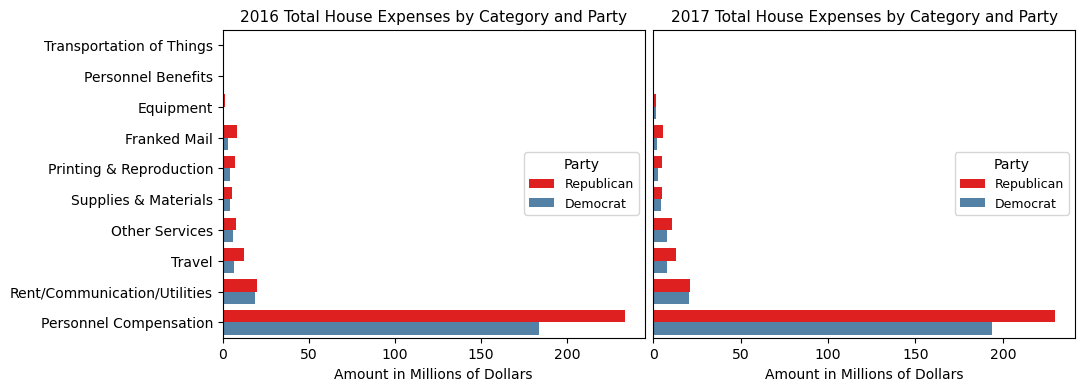

In [628]:
fig, axes = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(ax = axes[0], y='category', x='2016 Total', hue='Party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
axes[0].set_title('2016 Total House Expenses by Category and Party')
xfmt = '${x:,.0f}'
xtick = mtick.StrMethodFormatter(yfmt)
axes[0].xaxis.set_major_formatter(xtick)
axes[0].set_title('2016 Total House Expenses by Category and Party',fontsize=11)
sns.barplot(ax = axes[1],y='category', x='2017 Total', hue='Party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
axes[1].set_title('2017 Total House Expenses by Category and Party',fontsize=11)
axes[1].yaxis.set_visible(False)
axes[1].xaxis.set_major_formatter(xtick)
axes[1].set(xlabel='Amount')
axes[0].set(ylabel=None)
xlabs = ['0','50','100','150','200']
axes[0].set(xlabel='Amount in Millions of Dollars',xticklabels=xlabs)
axes[1].set(xlabel='Amount in Millions of Dollars',xticklabels=xlabs)

#lt.set_title('Total House Expenses by Category and Party')
plt.subplots_adjust(wspace=0.02, hspace=10)
pass

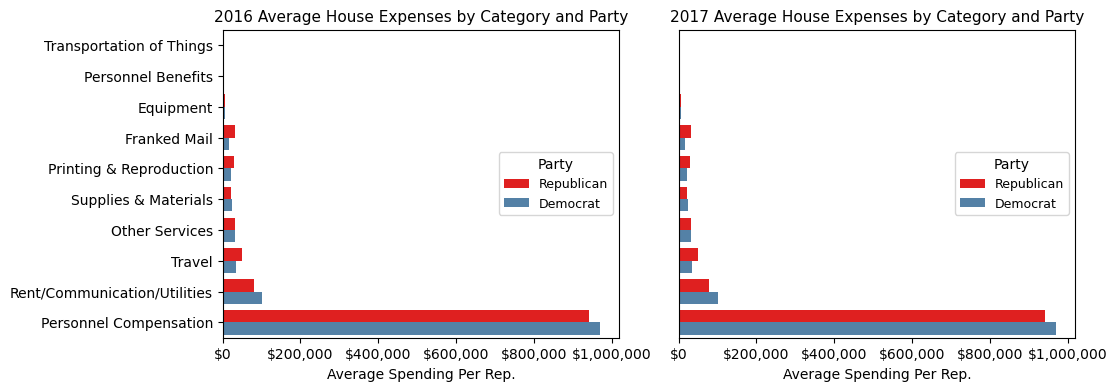

In [642]:
# add dollar signs/commas w/ tick formatter 
fig, axes = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(ax = axes[0], y='category', x='2016_avg_per_rep', hue='Party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
axes[0].set_title('2016 Average House Expenses by Category and Party')
xfmt = '${x:,.0f}'
xtick = mtick.StrMethodFormatter(yfmt)
axes[0].xaxis.set_major_formatter(xtick)
axes[0].set_title('2016 Average House Expenses by Category and Party',fontsize=11)
sns.barplot(ax = axes[1],y='category', x='2017_avg_per_rep', hue='Party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
axes[1].set_title('2017 Average House Expenses by Category and Party',fontsize=11)
axes[1].yaxis.set_visible(False)
axes[1].xaxis.set_major_formatter(xtick)
axes[1].set(xlabel='Average Spending Per Rep.')
axes[0].set(xlabel='Average Spending Per Rep.')
axes[0].set(ylabel=None)
# xlabs = ['0','50','100','150','200']
# axes[0].set(xlabel='Amount in Millions of Dollars',xticklabels=xlabs)
# axes[1].set(xlabel='Amount in Millions of Dollars',xticklabels=xlabs)

#lt.set_title('Total House Expenses by Category and Party')
plt.subplots_adjust(wspace=0.15, hspace=10)
pass

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.barplot(ax=axes[1][0],y='category', x='2016_avg_per_rep', hue='party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
axes[1][0].set_title('2016 Average House Expenses by Category and Party')
sns.barplot(ax=axes[1][1],y='category', x='2017_avg_per_rep', hue='party', data=by_cat_party,
            orient='h',palette=['red','steelblue'])
axes[1][1].set_title('2017 Average House Expenses by Category and Party')
pass


In [649]:
merge_df_no_DAL_office = merge_df_no_DAL.loc[merge_df_no_DAL['office'].str.startswith("OFFICE")]

In [651]:
merge_df_no_DAL_office.groupby(['party','year_quarter']).sum()

amount
party      year_quarter            
Democrat   2016Q1        1910934.76
           2016Q2        2057095.60
           2016Q3        2012297.30
           2016Q4        2202233.23
           2017Q1        1884060.61
           2017Q2        2028144.34
           2017Q3        2047481.61
           2017Q4        2360121.42
Republican 2016Q1        2363019.96
           2016Q2        2458315.04
           2016Q3        2543732.50
           2016Q4        2686687.30
           2017Q1        2320742.35
           2017Q2        2364874.66
           2017Q3        2512565.18
           2017Q4        2540300.27

In [662]:
office_by_party= merge_df_no_DAL_office.groupby(['party','office','year_quarter']).sum()#.unstack()#.sort_values(by='amount', ascending=False)
office_by_party= office_by_party.reset_index().sort_values(by='amount', ascending=False)

In [663]:
office_by_party.head(10)

,party,office,year_quarter,amount
7,Democrat,OFFICE OF THE MINORITY LEADER,2017Q4,1750881.84
3,Democrat,OFFICE OF THE MINORITY LEADER,2016Q4,1616781.39
35,Republican,OFFICE OF THE SPEAKER,2016Q4,1610355.60
34,Republican,OFFICE OF THE SPEAKER,2016Q3,1564195.96
38,Republican,OFFICE OF THE SPEAKER,2017Q3,1519643.06
39,Republican,OFFICE OF THE SPEAKER,2017Q4,1515904.42
33,Republican,OFFICE OF THE SPEAKER,2016Q2,1494924.17
1,Democrat,OFFICE OF THE MINORITY LEADER,2016Q2,1492952.20
6,Democrat,OFFICE OF THE MINORITY LEADER,2017Q3,1489964.85
37,Republican,OFFICE OF THE SPEAKER,2017Q2,1484828.84


### -----------------------------OLD (NOT USING)----------------------------------------------------------

#### ----------------------------- OLD MERGE (NOT USING)--------------------------------

In [ ]:
# how to merge:  left join ( keep all rows from main df and only 
# 1. rename id col to match 

# summ_all_df['id'] = summ_all_df['BIOGUIDE_ID']
#pd.merge(summ_all_df, congress_id_df, how="left", on = "id")
# merge_test_df = pd.merge(summ_all_df, congress_id_df, how="left", on = "id")

# left_on / right on: 
# left_on : label or list, or array-like
#     Column or index level names to join on in the left DataFrame. Can also
#     be an array or list of arrays of the length of the left DataFrame.
#     These arrays are treated as if they are columns.
# right_on : label or list, or array-like
#     Column or index level names to join on in the right DataFrame. Can also
#     be an array or list of arrays of the length of the right DataFrame.
#     These arrays are treated as if they are columns.


# validate ="many_to_one"  str, optional
#     If specified, checks if merge is of specified type.
#     * "many_to_one" or "m:1": check if merge keys are unique in right
#       dataset.
#     * "many_to_many" or "m:m": allowed, but does not result in checks.



In [ ]:
# merge_test_df.columns

In [ ]:
#merge_test_df[merge_test_df['id']== 'C001103']

In [ ]:
# mask = ((merge_test_df.BIOGUIDE_ID.notnull()) & (merge_test_df.congresses.isna()))
# merge_test_df[mask]

In [ ]:
# merge_test_df.shape

In [ ]:
# bioguide_allreps_df.info() # 424 ids 
# bioguide_id_df.info()

In [ ]:
# BIOGUIDE HAS 424 unique ids, but summ_id has 506---> WHY? 
# len(summ_id)

In [ ]:
# are all of the rep ids in the main expenditures df included in the ID df?
# summ_id = summ_all_df.BIOGUIDE_ID.unique()
# summ_ID = summ_all_df.BIOGUIDE_ID.unique()
# cong_id = congress_id_df.id.unique()

# #all(elem in summ_id for elem in cong_id) #--> false
# np.setdiff1d(summ_id,cong_id)
# not working b/c nans ?  check nans in main df id col
#summ_all_df[summ_all_df['BIOGUIDE_ID'].isna()]

# dp all of the non-missing IDs match ? 
summ_id = summ_id[1:] # remove nan from 0 index of array

# recheck 
all(elem in summ_id for elem in cong_id)
#np.setdiff1d(summ_id,cong_id)

#REVIEW USING LOC W/ BRACKETING
#summ_id.loc[summ_id[BIOGUIDE_ID.value_counts()

In [ ]:
# id_not_df2= np.setdiff1d(summ_id,cong_id)

#len(np.setdiff1d(summ_id,cong_id)) #437
#len(summ_id) # 503

In [ ]:
# try filtering id dataset

# no_id_df= summ_all_df[summ_all_df["BIOGUIDE_ID"].isin(id_not_df2)]
# no_id_df.OFFICE.value_counts()

In [ ]:
# try with new search json from bioguide id site
# bioguide_df = pd.read_json("search.json")
# bioguide_df.head()


In [ ]:
# summ_id = summ_all_df.BIOGUIDE_ID.unique()
# summ_id = summ_id[1:] # remove nan 

# cong_id = congress_id_df.id.unique()
# np.setdiff1d(summ_id,cong_id,assume_unique=True)
# 'A000374', 'A000370', 'A000055', 'A000371', 'A000372', 'A000367','A000369', 'A000373',
# summ_id = pd.Series(summ_id)
# summ_id.sort_values().head(100)
# A000374 = summ_id[0]
# bioguide_id = pd.Series(bioguide_id)
# bioguide_id.sort_values()

#?np.setdiff1d
# id_not_in_bioguide_df = np.setdiff1d(summ_id,bioguide_id)

# missing_bio_df = summ_all_df[summ_all_df["BIOGUIDE_ID"].isin(id_not_in_bioguide_df)]
# missing_bio_df.OFFICE.unique()

In [ ]:
# bioguide_allreps_df = pd.read_json("bioguide_all_reps.json")
# bioguide_allreps_df.head()

In [ ]:
# bioguide_allreps_id = bioguide_allreps_df.id.unique()
# id_not_in_bioguide_allreps_df = np.setdiff1d(summ_id,bioguide_allreps_id)
# missing_bio_df = summ_all_df[summ_all_df["BIOGUIDE_ID"].isin(id_not_in_bioguide_allreps_df)]
summ_df_offices_missing_id = missing_bio_df.OFFICE.unique()
# --> so basically could format "OFFICE" col to join on name in bioguide df ?


In [ ]:
# before wrangling the 'congresses' col and merging the 2 dataframes, filter to only the reps in the main df 
summ_ID = summ_all_df.BIOGUIDE_ID.unique()
len(summ_id)
#cong_id

In [ ]:
#### Re-run streamlined code with original dataset
# summ_all_df = pd.read_csv('summ_2016_2017_df.csv') # combined summary data for 2016-2017
# congress_id_df = pd.read_csv("congress ID.csv") # 2nd data for represenative name, party info 

# COuLD TRY: 
# headers = ['col1', 'col2', 'col3', 'col4']
# dtypes = {'Unnamed: 0':'int', 'BIOGUIDE_ID':'str', 'OFFICE':'str','YEAR':'float'}
# parse_dates = ['YEAR', 'QUARTER']
# pd.read_csv(file, sep='\t', header=None, names=headers, dtype=dtypes, parse_dates=parse_dates)
# parse_dates=parse_dates)

In [ ]:
# summ_all_df.head()

In [ ]:
# summ_all_df.info()

In [ ]:
# # drop unused index col 
# summ_all_df.drop(columns = 'Unnamed: 0', inplace=True)
# # fix col names
# summ_all_df.columns = summ_all_df.columns.str.lower()
# summ_all_df.columns

In [ ]:
# first, check if other committees have non-fiscal year values
# mask = ( (summ_all_df['bioguide_id'].isnull()) & (summ_all_df['year'] != "FISCAL YEAR 2016") )
# summ_all_df.loc[mask].info()
# --> quite a few, actually, so filter based on null bioguide_id only

In [ ]:
# missing_id_df = summ_all_df.loc[summ_all_df['bioguide_id'].isnull()]
# missing_id_df.office.unique()

### -----------------------------EARLY VERSION OF OFFICE IMPUTING (NOT USING)--------------------------------

In [ ]:
# #'HON. 13TH DISTRICT OF MICHIGAN': John Conyers, Jr. Democrat, MI, 113th-115th (2013-2017) 
# bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Conyers"]

# # HON. 18TH DISTRICT OF PENNSYLVANIA: either Tim Murphy, Republican, PA, 108th-115th (2015-2017) OR ??
# bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Murphy"]

# # 'HON. 8TH DISTRICT OF ARIZONA': #Trent Franks, Republican, AZ, 113th-115th (2013-2017) 
# bioguide_reps_20152019_df.loc[bioguide_reps_20152019_df['last_name'] == "Franks"


# # just make a  dictionary for function? 
# office_id_dict = {'HON. 13TH DISTRICT OF MICHIGAN':'C000714', # John Conyers, Jr. Democrat, MI, 113th-115th (2013-2017)
#                   # NOTE: John Conyers resigned 12/17 due to sexual harassment scandal 
#                   'HON. 18TH DISTRICT OF PENNSYLVANIA': 'M001151', # Tim Murphy, Republican, PA, 108th-115th (2015-2017
#                   # NOTE: Tim Murphy resigned 10/17 ("urged a mistress to have an abortion, despite his strict public anti-abortion stance...
#                   # This was followed by reports of endemic abuse and harassment in his congressional office.
#                   # Murphy resigned immediately following these scandals, with his seat claimed by Democrat Conor Lamb in a special election."
#                   'HON. 8TH DISTRICT OF ARIZONA':'F000448', #Trent Franks, Republican, AZ, 113th-115th (2013-2017)
#                   # NOTE: resigned 12/17, 
#                   # "In December 2017, the House Ethics Committee announced that it would investigate allegations of sexual harassment against Franks.
#                   # Franks had repeatedly asked two female staffers to bear his children as surrogate mothers; 
#                   # he allegedly offered one of them $5 million to carry his child.
#                   # The women feared that Franks wanted to impregnate them sexually as part of the surrogacy process.
#                   # Franks acknowledged discussing surrogacy with the aides but denied the other allegations; 
#                   # he resigned from Congress immediately after the ethics investigation was announced, 
#                   # blaming his situation on "the current cultural and media climate" " 
#                   'OFFICE OF THE SPEAKER':'R000570', # Paul D. Ryan, Republican, WI, 115th (2015–2017)
#                   'OFFICE OF THE MAJORITY LEADER':'M001165', #Kevin McCarthy, Republican, CA, 114th (2015–2017)
#                   'OFFICE OF THE MINORITY LEADER':'P000197', #Nancy Pelosi, Democrat, CA, 115th (2017–2019)
#                   'OFFICE OF THE MAJORITY WHIP':'S001176', #Steve Scalise, Republican, LA, 114th (2015–2017)
#                   'OFFICE OF THE MINORITY WHIP':'H000874', # Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017
#                   '2017 OFFICE OF THE SPEAKER':'R000570', # Paul Ryan
#                   '2017 OFFICE OF THE MAJORITY LEADER':'M001165', #Kevin McCarthy, Republican, CA, 114th (2015–2017)
#                   '2017 OFFICE OF THE MINORITY LEADER':'P000197', #Nancy Pelosi, Democrat, CA, 115th (2017–2019)
#                   '2017 OFFICE OF THE MAJORITY WHIP':'S001176', #Steve Scalise, Republican, LA, 114th (2015–2017), 
#                   '2017 OFFICE OF THE MINORITY WHIP':'H000874'# Steny Hamilton Hoyer, Democrat, MD, 114th (2015–2017
#                  }

### -----------------------------CONVERT OFFICE COL TO NAMES (NOT USING)--------------------------------

In [ ]:
#1. remove "HON. " prefixes
#missing_bio_df['OFFICE2'] = missing_bio_df['OFFICE'].str.replace('HON. ','')
# missing_bio_df.head()
# make dict of old value/ new value s? 

- At this point, I'm not clear why some of the IDs on the main df are missing from the ID df given that the latter is comprensive. 
- There do appear to be some discrepancies in the names (whether nicknames are included, etc.I will try formatting the "office" column into individual names that might be able to be matched with the id data using name fields 

In [ ]:
# trying to split up office col into 5 total cols (to cover for title prefixes, middle names, etc.) 
#summ_all_df.columns
# summ_all_df.columns

# summ_all_df[['title','name_1','name_2','name_3','name_4']] = summ_all_df["OFFICE"].str.split(' ',4,expand=True)
# summ_all_df.head()
#summ_all_df.name_2.unique()

# CHECK
#summ_all_df['name_4'].isna().sum()
#summ_all_df.loc[summ_all_df['name_4']  ()]

#missing_bio_df.loc[missing_bio_df['OFFICE2'].str.contains(".")]

#new = missing_bio_df["OFFICE"].str.split(" ")
#missing_bio_df["first_name"]= 

# missing_bio_df.head()


# missing_bio_df["first_name"]= new[0]
# missing_bio_df.head()
# # making separate last name column from new data frame
# data["Last Name"]= new[1]
# missing_bio_df.OFFICE[0]

In [ ]:
# missing_bio_df['OFFICE3'] = missing_bio_df['OFFICE2'].str.capitalize()
# missing_bio_df.head()

In [ ]:
#bioguide_allreps_df.familyName.sort_values()
#bioguide_allreps_df[bioguide_allreps_df['familyName'] == "Soto"]

In [ ]:

# MAKE NEW COL W/O HON PREFIX 
#summ_all_df['OFFICE_noHON'] = summ_all_df['OFFICE'].str.replace('HON. ','')
# summ_all_df[summ_all_df['OFFICE_noHON']=="RICK W. ALLEN"]


In [ ]:
# CHECK 
#summ_all_df[summ_all_df['OFFICE_noHON']=="RICK W. ALLEN"]


In [ ]:
# missing_bio_df['OFFICE'].unique()

In [ ]:
# CHECK IF ALL PERIODS ARE FOR 3-PART NAMES 
#summ_all_df['OFFICE_noHON']
#missing_bio_df['OFFICE'].str.contains(".")

# look at example row for buddy carter
# congress_id_df[congress_id_df['familyName']=="Carter"] # C001103

In [ ]:
# summ_all_df[summ_all_df['BIOGUIDE_ID']=='C001103']
# --> why is an id in both dfs not being idenitified in th 2nd (according to setdiff?) 

### -----------------------------END CONVERT OFFICE COL TO NAMES (NOT USING)--------------------------------

### -----------------------------CONVERT OFFICE COL TO NAMES PART 2 (NOT USING)--------------------------------

In [ ]:
# 1. subset only rows without null "BIOGUIDE_ID" (which are groups not individuals)
## remove "2017 " prefix to align all office fields for split 
# mask = ( (summ_all_df["office"].str.startswith("2017")) & (summ_all_df["bioguide_id"].isnull()) )
# no_id_2017_df = summ_all_df[mask]
# no_id_2017_df.office.unique() # 33 committees/groups 

# summ_all_df["office_temp"] = summ_all_df["office"].str.replace("2017 ","") 
# --> this will mess up group names, but they aren't going to be used in the name columns anyway 

In [ ]:
## split office col in main df into individual title/name columns 
# summ_all_df[['title','name_1','name_2','name_3','name_4','name_5']] = summ_all_df["office_temp"].str.split(' ',5,expand=True)
# summ_all_df.head()

In [ ]:
# is there any data in the 5th name col? 
# summ_all_df.name_5.value_counts()
# --> it looks like there are a few individual names that need this many columns based on the Jr./Sr./III suffixes
# but everything looks like comittee names, which won't matter anways 

### -----------------------------CONVERT OFFICE COL TO NAMES PART 2 (NOT USING)--------------------------------